In [50]:
import torch as th
import torch
import numpy as np
from Codes.Losses.gradImSnake import cmptExtGrad
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr
import torch.nn.functional as F
import networkx as nx
from math import sin, pi, cos
from matplotlib.path import Path
import matplotlib.pyplot as plt
import math
from functools import reduce

In [76]:
import numpy as np
from functools import reduce
import torch as th
from Codes.Losses.renderLineGraph import renderGraph
from Codes.Losses.renderDistanceMap import renderDistBig
from Codes.Losses.cropGraph import nodeInside, cropGraph

def getA(G,alpha,beta,dims):
    # G is an nx.graph
    #   nodes have attributes "pos", nd-arrays, encoding their positions
    #   (note, that the order of the dimensions is not reversed)
    #   some nodes have an attribute "fixedDim", a scalar
    # alhpha is a scalar
    # beta is a scalar
    #
    # let u,v,w denote snake control points
    # let E be the set of snake edges
    # let T be the set of triplets (u,v,w), such that u and w are the only neighbors of v
    # the snake energy is \alpha\sum_{(u,v)\in E} |u-v|^2 + \beta\sum_{(u,v,w)\in T} |u-2v+w|^2
    # Note, that the energy can be separated across dimensions of the space in which the control points live
    # 
    # the gradient of the snake energy with respect to control point coordinates in one of the dimensions
    # can be expressed as Ax, where A is a matrix and x is a vector of positions of snake control points
    # 
    # this function computes the matrix A for each dimension and
    # returns:
    #     a tensor A of size k X k X d, where A[:,:,i] is the matrix A for dimension i
    #     a tensor snake0 of size k X d, containing the positions of snake control points
    #     a boolean tensor fixedDim of size k X d,
    #         where fixedDim[i,j]=True if j-th coordinate of point i should be frozen
    #         we freeze coordinates of points that are on the boundary of a crop (see cropGraph)
    #     a mapping node2ind from graph nodes to indices of snake0 and fixedDim
    
    ind=0
    node2ind={}
    for n in G.nodes:
        node2ind[n]=ind
        ind+=1
    
    A       =np.zeros((ind,ind,dims))
    snake0  =np.zeros((ind,dims))
    fixedDim=np.zeros((ind,dims),dtype=np.bool)
    
    for u,v in G.edges:
        # add the gradient of \alpha|u-v|^2
        # with respect to u and v
        i1=node2ind[u]
        i2=node2ind[v]
        A[i1,i1]+= alpha
        A[i1,i2]+=-alpha
        A[i2,i2]+= alpha
        A[i2,i1]+=-alpha
        
    for n in G.nodes:
        i1=node2ind[n]
        snake0[i1]=G.nodes[n]["pos"]
        if len(G[n])==2:
            # add the gradient of \beta|u-2v+w|^2
            # with respect to u,v and w
            n2,n3=G[n]
            i2,i3=node2ind[n2],node2ind[n3]
            A[i1,i1]+= 4*beta
            A[i1,i2]+=-2*beta
            A[i1,i3]+=-2*beta
            A[i2,i1]+=-2*beta
            A[i3,i1]+=-2*beta
            A[i2,i2]+=   beta
            A[i3,i3]+=   beta
            A[i2,i3]+=   beta
            A[i3,i2]+=   beta
        if "fixedDim" in G.nodes[n]:
            # zero the gradient for fixed nodes
            A[i1,:,G.nodes[n]["fixedDim"]]=0.0
            fixedDim[i1,G.nodes[n]["fixedDim"]]=True
    
    return A,snake0,fixedDim,node2ind

def invertALambdaI(A,stepsz):
    # A is shaped k x k x d
    # stepsz is a scalar
    # returns C shaped k x k x d
    # where C[:,:,i]=(stepsz*A[:,:,d]+I)^-1
    invs=[]
    for d in range(A.shape[-1]):
        invs.append(np.linalg.inv(stepsz*A[:,:,d]+np.eye(A.shape[0])))
        
    return np.stack(invs,axis=2)

def snakeStep(snakepos,extgrad,cmat,stepsz):
    # the update equation is ((stepsz*A+I)^-1)*(snakepos-stepsz*extgrad)
    # cmat represents (stepsz*A+I)^-1
    #
    # all the arguments are torch tensors
    # snakepos  is a k X d matrix, where snakepos[i,j,:] represents a d-dimensional position of the j-th node of the i-th snake
    # extgrad   is a k X d matrix, where extgrad[i,j,:] represents the gradient of the external energy of the i-th snake w.r.t. the j-th control point
    # cmat      is a k X k X d tensor; cmat[:,:,i] is a matrix (stepsz*A+I)^-1 for dimension i
    # stepsz    is a scalar; it is the implicit step size
    # 
    # this function returns newsnakepos= cmat * (snakepos - stepsz*extparam*extgrad)
    # where the first multiplication is matrix-vector;
    # this calculation should be performed separately for each dimension 0<=i<d
    
    # we can pack the calculation into a single function call
    newsnakepos=th.einsum("lkd,kd->ld",[cmat,snakepos-stepsz*extgrad])
    
    return newsnakepos

class Snake():
    # represents the topology, position, and internal energy of a single snake
    # this class lets evolve the position of snake control points to minimize 
    # the sum of internal and external energies
    # the internal energy is:
    #   let u,v,w denote snake control points
    #   let E be the set of snake edges
    #   let T be the set of triplets (u,v,w), such that u and w are the only neighbors of v
    #   the snake energy is \alpha \sum_{(u,v)\in E} |u-v|^2 + \beta \sum_{(u,v,w)\in T} |u-2v+w|^2
    # the gradient of the external energy is delivered as the argument of the step method
    # 
    
    def __init__(self,graph,crop,stepsz,alpha,beta,ndims):
        # a snake is created for a crop of a graph
        #
        # graph is an nx.graph
        #   nodes have attributes "pos", nd-arrays, encoding their positions
        #   (note, that the order of the dimensions is not reversed)
        # crop is a tuple of slice objects; it defines a hypercube;
        #   the snake consists of the sub-graph of "graph" that contains nodes in this hypercube
        #   edges crossing the faces of the hypercube are cut and new nodes on the faces are created
        #   these nodes are constrained to lie on the faces
        # stepsz, a scalar, is the implicit step size
        # alpha is a scalar, the coefficient of the pairwise (spring) internal energy term
        # beta is a scalar, the coefficient of the triplet (curvature) internal energy term
        # ndims should equal 2 or 3, and is the number of dimensions of the space in which the graph nodes live
        #
        
        self.stepsz=stepsz
        self.alpha =alpha
        self.beta  =beta
        self.ndims=ndims
        
        self.h=graph
        a,s,fd,n2i=getA(self.h,self.alpha,self.beta,self.ndims)
        c=invertALambdaI(a,self.stepsz)
        self.c = th.from_numpy(c).type(th.float32)
        self.s = th.from_numpy(s).type(th.float32)
        self.fd= th.from_numpy(fd.astype(np.uint8))>0
        self.n2i=n2i
    
    def cuda(self):
        self.c =self.c .cuda()
        self.s =self.s .cuda()
        self.fd=self.fd.cuda()
    
    def step(self,gradext):
        # update the position of the control nodes
        # using the external gradient "gradext"
        # gradext should have the same shape as self.s

        gradext[self.fd]=0.0
        self.s=snakeStep(self.s,gradext,self.c,self.stepsz)
        return self.s
    
    def getPos(self):
        return self.s
    
    def getGraph(self):
        # returns a graph reflecting the current position of snake nodes
        # note, that the graph only contains the nodes that lie within the crop area
        # (see the init method)
        s=self.s.cpu().detach().numpy()
        g=self.h.copy()
        for n in g.nodes:
            g.nodes[n]["pos"]=s[self.n2i[n],:]
        
        return g
    
    def renderSnakeWithLines(self,lbl):
        g=self.getGraph()
        maxv = lbl.shape
        return renderGraph(lbl,g,maxv=np.array(maxv)-1)

    def renderDistanceMap(self,size,cropsz,dmax,maxedgelen):
        # size is the size of the distance bolume, an interable of ints
        # cropsz defines the size of the crop to use when rendering the map
        # (smaller crop - less memory needed)
        # it is an interable  of ints 
        # dmax is the value used to cap the distance map as D[i]=min(dist[i],dmax)
        # maxedgelen is the maximum edge length in the graph
        return renderDistBig(self.getGraph(),self.getPos(),self.n2i,size,
                             cropsz,dmax,maxedgelen)




In [88]:
class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, dim):
        # In the new version grad will be separate, so image gradients will not be here
        # Normal initialization of Snake super class
        super().__init__(graph, crop, stepsz, alpha, beta, dim)
        # Additionally we sample from a normal distrubution for widths of nodes
        #self.w = torch.ones(self.s.shape[0]).abs()
        self.w = torch.randint(low=2, high=9, size=(self.s.shape[0],), dtype=torch.float32)

    def cuda(self):
        super().cuda()
        # move the widths to gpu
        self.w = self.w.cuda()

    def set_w(self, widths):
        self.w = widths

    def get_w(self):
        return self.w

    def _compute_normals(self, pos):
        """
        Compute normals (and tangents for 3D) for each center point.
        Returns:
         - 2D: (normals,) where normals is (N,2)
         - 3D: (n1, n2, tangents) each (N,3)
        """
        N, d = pos.shape
        eps = 1e-8
        t = torch.zeros_like(pos)
        if N > 1:
            t[1:-1] = (pos[2:] - pos[:-2]) * 0.5
            t[0] = pos[1] - pos[0]
            t[-1] = pos[-1] - pos[-2]
        t = t / (t.norm(dim=1, keepdim=True) + eps)

        if self.ndims == 2:
            normals = torch.stack([-t[:,1], t[:,0]], dim=1)
            normals = normals / (normals.norm(dim=1, keepdim=True) + eps)
            return (normals,)
        else:
            a = torch.zeros_like(pos)
            a[:] = torch.tensor([1.0, 0.0, 0.0], device=pos.device)
            mask = (t * a).abs().sum(dim=1) > 0.9
            a[mask] = torch.tensor([0.0, 1.0, 0.0], device=pos.device)
            n1 = torch.cross(t, a, dim=1)
            n1 = n1 / (n1.norm(dim=1, keepdim=True) + eps)
            n2 = torch.cross(t, n1, dim=1)
            n2 = n2 / (n2.norm(dim=1, keepdim=True) + eps)
            return (n1, n2, t)
        
    def comp_second_deriv(self):
        """
        Computes an internal smoothness term for widths, related to the second derivative,
        using 1D convolution. Handles boundaries using padding.
        A positive value indicates the width should shrink to increase smoothness,
        a negative value indicates it should grow.
        Returns:
            torch.Tensor: Smoothness term for each node, shape (K, 1).
        """
        K = self.w.numel()
        if K < 3:
             return torch.zeros(K, 1, device=self.w.device, dtype=self.w.dtype)

        w = self.w.view(1, 1, -1)

        kernel = torch.tensor([[[1.0, -2.0, 1.0]]], device=w.device, dtype=w.dtype) # Shape (1, 1, 3)
        padding_size = (kernel.shape[-1] - 1) // 2
        w_padded = F.pad(w, (padding_size, padding_size), mode='replicate')
        smoothness_term = F.conv1d(w_padded, kernel, padding=0)
        return -smoothness_term.view(-1, 1) # Shape (K, 1)

    def step_widths(self, gimgW):
        """
        Update widths by sampling gradient of image W at ribbon edges and
        adding internal smoothness via second derivative.
        Handles leaf nodes using padded convolution for smoothness.
        """
        if self.s.numel() == 0:
            return self.w

        pos = self.s
        K, d = pos.shape
        device = pos.device
        w_vec = self.w.view(-1)
        half_r = (w_vec / 2.0).view(K, 1)

        if d == 2:
            (normals,) = self._compute_normals(pos)
            left_pts  = pos - normals * half_r    
            right_pts = pos + normals * half_r    
            grad_L = cmptExtGrad(left_pts,  gimgW)
            grad_R = cmptExtGrad(right_pts, gimgW)
            grad_w = ((grad_R - grad_L) * normals).sum(dim=1, keepdim=True)

        elif d == 3:
            n1, n2, _ = self._compute_normals(pos)
            N_samples = 8
            theta = torch.linspace(0, 2*math.pi, N_samples + 1, device=device, dtype=pos.dtype)[:-1]
            theta_exp = theta.view(N_samples, 1, 1)
            n1_exp = n1.unsqueeze(0)                
            n2_exp = n2.unsqueeze(0)                
            half_r_exp = half_r.view(1, K, 1)       
            pos_exp = pos.unsqueeze(0)              
            dirs = theta_exp.cos() * n1_exp + theta_exp.sin() * n2_exp
            epsilon_offset = 1e-4
            pts_out = pos_exp + (half_r_exp + epsilon_offset) * dirs  
            pts_in  = pos_exp - (half_r_exp + epsilon_offset) * dirs  
            all_pts = torch.cat([pts_out, pts_in], dim=0) 
            all_pts_flat = all_pts.view(-1, 3)           
            grads_flat = cmptExtGrad(all_pts_flat, gimgW)
            grads = grads_flat.view(2*N_samples, K, 3)   
            grads_out = grads[:N_samples]
            grads_in  = grads[N_samples:]
            grad_diff = grads_out - grads_in
            radial_component = (grad_diff * dirs).sum(dim=2)
            grad_w = radial_component.mean(dim=0, keepdim=True).t()

        else:
            raise ValueError(f"Unsupported dimension: {d}")

        internal = self.comp_second_deriv()
        alpha = grad_w.abs() / (internal.abs().max(torch.tensor(1e-8, device=device)))
        alpha = torch.clamp(alpha, max=10.0)
        total_gradient = -grad_w - alpha * internal

        # gradient descent step: w_new = w_old - stepsz * total_gradient
        self.w = w_vec + self.stepsz * total_gradient.squeeze(-1)
        self.w = torch.clamp(self.w, min=1e-4)
        return self.w
    
    def render_distance_map_with_widths(self, size, max_dist=16.0):
        """
        Unified 2D/3D signed distance map for the ribbon snake using graph structure.

        Args:
            size (tuple): (W, H) for 2D or (X, Y, Z) for 3D grid dimensions.
            max_dist (float): Maximum distance value to clamp to.

        Returns:
            torch.Tensor: Signed distance map of shape `size`. Negative inside,
                          zero on surface, positive outside up to max_dist.
        """
        device = self.s.device
        centers = self.s
        radii = (self.w.flatten() / 2.0)
        eps = 1e-8

        if centers.numel() == 0 or radii.numel() == 0 or len(self.h.nodes) == 0:
            print("Warning: Rendering distance map for empty snake.")
            return torch.full(size, max_dist, device=device, dtype=centers.dtype)

        if centers.shape[0] != radii.shape[0]:
             raise ValueError(f"Mismatch between center points ({centers.shape[0]}) and radii ({radii.shape[0]})")

        axes = [torch.arange(sz, device=device, dtype=torch.float32) for sz in size]
        mesh = torch.meshgrid(*axes, indexing='ij')
        points = torch.stack([m.flatten() for m in mesh], dim=1)
        num_points = points.shape[0]
        min_dist = torch.full((num_points,), float('inf'), device=device, dtype=centers.dtype)

        if len(self.h.edges) > 0:
            try:
                if hasattr(self, 'n2i') and self.n2i:
                     edge_indices_list = [(self.n2i[u], self.n2i[v]) for u, v in self.h.edges]
                else:
                     edge_indices_list = list(self.h.edges)

                edge_indices = torch.tensor(edge_indices_list, device=device, dtype=torch.long) # (E, 2)
                del edge_indices_list
            except KeyError as e:
                 raise RuntimeError(f"Node ID {e} from graph edges not found in n2i mapping. Ensure Snake init populated n2i correctly.") from e
            except Exception as e:
                 raise RuntimeError(f"Error processing graph edges. Ensure self.h and self.n2i are correct. Original error: {e}")


            starts = centers[edge_indices[:, 0]]
            ends   = centers[edge_indices[:, 1]]
            r0     = radii[edge_indices[:, 0]]
            r1     = radii[edge_indices[:, 1]]

            vec = ends - starts
            L_sq = (vec**2).sum(dim=1)
            valid_edge = L_sq > eps**2
            if torch.any(valid_edge):
                 starts_v, ends_v = starts[valid_edge], ends[valid_edge]
                 r0_v, r1_v = r0[valid_edge], r1[valid_edge]
                 vec_v = vec[valid_edge]
                 L_sq_v = L_sq[valid_edge]
                 L_v = torch.sqrt(L_sq_v + eps)
                 D_v = vec_v / (L_v.unsqueeze(1) + eps)

                 P_exp = points.unsqueeze(1)
                 S_exp = starts_v.unsqueeze(0)
                 D_exp = D_v.unsqueeze(0)
                 L_exp = L_v.unsqueeze(0)

                 v_point_start = P_exp - S_exp
                 proj = (v_point_start * D_exp).sum(dim=2)
                 t = torch.clamp(proj, min=torch.tensor(0.0, device=device), max=L_exp)

                 closest_on_axis = S_exp + D_exp * t.unsqueeze(-1)
                 dist_axis_sq = ((P_exp - closest_on_axis)**2).sum(dim=2)
                 frac = t / torch.clamp(L_exp, min=eps)
                 r0_exp = r0_v.unsqueeze(0)
                 r1_exp = r1_v.unsqueeze(0)
                 interp_radius = r0_exp * (1.0 - frac) + r1_exp * frac
                 dist_sq_capsule = dist_axis_sq - interp_radius**2
                 dist_axis = torch.sqrt(torch.clamp(dist_axis_sq, min=eps))
                 signed_dist_capsule = dist_axis - interp_radius
                 min_dist_capsule, _ = signed_dist_capsule.min(dim=1)

                 min_dist = torch.minimum(min_dist, min_dist_capsule)
                 # P_exp is still needed for sphere calculation

        if centers.shape[0] > 0:
            # Reuse P_exp if it exists from capsule calculation
            if 'P_exp' not in locals():
                P_exp = points.unsqueeze(1)
            C_exp = centers.unsqueeze(0)
            R_exp = radii.unsqueeze(0)
            dist_to_centers_sq = ((P_exp - C_exp)**2).sum(dim=2)
            dist_to_centers = torch.sqrt(torch.clamp(dist_to_centers_sq, min=eps))

            signed_dist_sphere = dist_to_centers - R_exp
            min_dist_sphere, _ = signed_dist_sphere.min(dim=1)
            min_dist = torch.minimum(min_dist, min_dist_sphere)

        dist_clamped = torch.clamp(min_dist, max=max_dist)
        return dist_clamped.reshape(*size)

In [89]:
def makeGaussEdgeFltr(stdev,d):
    # make a Gaussian-derivative-based edge filter
    # filter size is determined automatically based on stdev
    # the filter is ready to be used with pytorch conv 
    # input params:
    #   stdev - the standard deviation of the Gaussian
    #   d - number of dimensions
    # output:
    #   fltr, a np.array of size d X 1 X k X k,
    #         where k is an odd number close to 4*stdev
    #         fltr[i] contains a filter sensitive to gradients
    #         along the i-th dimension

    fsz=round(2*stdev)*2+1 # filter size - make the it odd

    n=np.arange(0,fsz).astype(float)-(fsz-1)/2.0
    s2=stdev*stdev
    v=np.exp(-n**2/(2*s2)) # a Gaussian
    g=n/s2*v # negative Gaussian derivative

    # create filter sensitive to edges along dim0
    # by outer product of vectors
    shps = np.eye(d,dtype=int)*(fsz-1)+1
    reshaped = [x.reshape(y) for x,y in zip([g]+[v]*(d-1), shps)]
    fltr=reduce(np.multiply,reshaped)
    fltr=fltr/np.sum(np.abs(fltr))
    
    # add the out_channel, in_channel initial dimensions
    fltr_=fltr[np.newaxis,np.newaxis]
    # transpose the filter to be sensitive to edges in all directions 
    fltr_multidir=np.concatenate([np.moveaxis(fltr_,2,k) for k in range(2,2+d)],axis=0)
    
    return fltr_multidir

def cmptGradIm(img,fltr):
    # convolves img with fltr, with replication padding
    # fltr is assumed to be of odd size
    # img  is either 2D: batch X channel X height X width
    #             or 3D: batch X channel X height X width X depth
    #      it is a torch tensor
    # fltr is either 2D: 2 X 1 X k X k
    #             or 3D: 3 X 1 X k X k X k
    #      it is a torch tensor
    
    if img.dim()==4:
        img_p=torch.nn.ReplicationPad2d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv2d(img_p,fltr)
    if img.dim()==5:
        img_p=torch.nn.ReplicationPad3d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv3d(img_p,fltr)
    else:
        raise ValueError("img should have 4 or 5 dimensions")

def cmptExtGrad(snakepos,eGradIm):
    # returns the values of eGradIm at positions snakepos
    # snakepos  is a k X d matrix, where snakepos[j,:] represents a d-dimensional position of the j-th node of the snake
    # eGradIm   is a tensor containing the energy gradient image, either of size
    #           3 X d X h X w, for 3D, or of size
    #           2     X h X w, for 2D snakes
    # returns a tensor of the same size as snakepos,
    # containing the values of eGradIm at coordinates specified by snakepos
    
    # scale snake coordinates to match the hilarious requirements of grid_sample
    # we use the obsolote convention, where align_corners=True
    scale=torch.tensor(eGradIm.shape[1:]).reshape((1,-1)).type_as(snakepos)-1.0
    sp=2*snakepos/scale-1.0
    
    if eGradIm.shape[0]==3:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('km,md->kd',[sp,torch.tensor([[0,0,1],[0,1,0],[1,0,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,4,1)
    if eGradIm.shape[0]==2:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('kl,ld->kd',[sp,torch.tensor([[0,1],[1,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,1)
        
    return egrad.reshape_as(snakepos)

class GradImRib(RibbonSnake):
    def __init__(self, graph, crop,stepsz, alpha, beta, dim, gimgV, gimgW):
        super().__init__(graph, crop,stepsz, alpha, beta, dim)

        self.gimgV = gimgV.clone()
        self.gimgW = gimgW.clone()
    
    def cuda(self):
        super().cuda()
        if self.gimgV is not None:
            self.gimgV = self.gimgV.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()

    def step(self):
        return super().step(cmptExtGrad(self.s, self.gimgV))
    
    def step_widths(self):
        return super().step_widths(self.gimgW)
    
    def optim(self, niter, niter_width):
        if len(self.s) > 0:
            for _ in range(niter):
                self.step()
            for _ in range(niter_width):
                self.step_widths()
        return self.s

In [90]:
def show_slices(distance_map, graph):
    """Show orthogonal slices through the distance map"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    xx = np.min(distance_map, axis=0)
    yy = np.min(distance_map, axis=1)
    zz = np.min(distance_map, axis=2)
    
    im0 = axes[0].imshow(xx.T, cmap='coolwarm')
    axes[0].set_title('Slice (X)')
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(yy.T, cmap='coolwarm')
    axes[1].set_title('Slice (Y)')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(zz.T, cmap='coolwarm')
    axes[2].set_title('Slice (Z)')
    fig.colorbar(im2, ax=axes[2])

    for edge in graph.edges:
        node1, node2 = edge
        x1, y1, z1 = graph.nodes[node1]['pos']
        x2, y2, z2 = graph.nodes[node2]['pos']
        
        axes[0].plot([y1, y2], [z1, z2], 'r-')
        axes[1].plot([x1, x2], [z1, z2], 'r-')
        axes[2].plot([x1, x2], [y1, y2], 'r-')
    
    plt.show()

In [91]:
def show(img,title,graph=None):
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.show()

# With Loss

In [92]:
import torch.nn as nn
import torch.optim as optim

In [93]:
class SnakeFastLoss(nn.Module):
    def __init__(self, stepsz, alpha, beta, fltrstdev, ndims, nsteps,
                 cropsz, dmax, maxedgelen, extgradfac):
        super(SnakeFastLoss, self).__init__()
        self.stepsz = stepsz
        self.alpha = alpha
        self.beta = beta
        self.fltrstdev = fltrstdev
        self.ndims = ndims
        self.cropsz = cropsz
        self.dmax = dmax
        self.maxedgelen = maxedgelen
        self.extgradfac = extgradfac
        self.nsteps = nsteps

        self.fltr = makeGaussEdgeFltr(self.fltrstdev, self.ndims)
        self.fltrt = torch.from_numpy(self.fltr).type(torch.float32)

        self.iscuda = False

    def cuda(self):
        super(SnakeFastLoss, self).cuda()
        self.fltrt = self.fltrt.cuda()
        self.iscuda = True
        return self

    def forward(self, pred_dmap, lbl_graphs, crops=None, mask= None):
        # pred_dmap is the predicted distance map from the UNet
        # lbl_graphs contains graphs each represent a label as a snake
        # crops is a list of slices, each represents the crop area of the corresponding snake

        pred_ = pred_dmap
        dmapW = torch.abs(pred_).clone()
        gimgW = cmptGradIm(dmapW, self.fltrt)
        gimg = cmptGradIm(pred_, self.fltrt)
        gimg *= self.extgradfac
        gimgW *= self.extgradfac
        snake_dmap = []

        for i, lg in enumerate(zip(lbl_graphs, gimg, gimgW)):
            # i is index num
            # lg is a tuple of a graph and a gradient image
            l = lg[0]  # graph
            g = lg[1]  # gradient image
            gw = lg[2]

            s = GradImRib(graph=l, crop=self.cropsz, stepsz=self.stepsz, alpha=self.alpha,
                        beta=self.beta,dim=self.ndims, gimgV=g, gimgW=gw)
                    
            if self.iscuda: 
                s.cuda()

            s.optim(self.nsteps, self.nsteps)
            dmap = s.render_distance_map_with_widths(g[0].shape)
            #cropsz_for_render = tuple(cs.stop - cs.start for cs in self.cropsz)
            #dmap = s.renderDistanceMap(g[0].shape, cropsz_for_render, 16, 4)
            #show_slices(dmap.numpy(), l)
            if mask is not None:
                dmap = dmap * (mask==0)
            snake_dmap.append(dmap)

        snake_dm = torch.stack(snake_dmap, 0).unsqueeze(1)   
        loss = ((pred_dmap - snake_dm)**2).mean()
        self.snake = s
        return loss

In [94]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def show_ribbon_3d(snake, ax=None):
    """
    Visualizes a 3D RibbonSnake object as a cylindrical shape.

    Args:
        snake: An instance of the RibbonSnake class.
        ax: Optional matplotlib 3D axes to plot on. If None, a new figure and axes are created.
    """
    if not hasattr(snake, 's') or snake.s.numel() == 0:
        print("Snake is empty or does not have positions (s attribute), cannot visualize.")
        return

    if not hasattr(snake, 'ndims') or snake.ndims != 3:
        print(f"This visualization is for 3D snakes. Snake is {getattr(snake, 'ndims', 'unknown')}D.")
        return

    if not hasattr(snake, '_compute_normals'):
        print("Snake object does not have a '_compute_normals' method. Cannot compute ribbon orientation.")
        return
        
    if not hasattr(snake, 'h') or not hasattr(snake, 'n2i'):
        print("Snake object is missing graph (h) or node_to_index map (n2i).")
        return

    created_ax = False
    if ax is None:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        created_ax = True

    pos_cpu = snake.s.cpu().detach()
    widths_cpu = snake.w.cpu().detach().flatten() / 2.0  # half-widths (radii)
    
    n1_all_cpu, n2_all_cpu, _ = snake._compute_normals(pos_cpu)

    graph = snake.h 
    node_to_idx = snake.n2i
    
    all_x, all_y, all_z = [], [], []
    centerline_plotted_label = False

    # Plot centerline
    if graph.nodes:
        for u_graph_id, v_graph_id in graph.edges():
            if u_graph_id not in node_to_idx or v_graph_id not in node_to_idx:
                print(f"Warning: Edge ({u_graph_id}, {v_graph_id}) contains nodes not in n2i map. Skipping.")
                continue
            u_idx, v_idx = node_to_idx[u_graph_id], node_to_idx[v_graph_id]
            p1_np, p2_np = pos_cpu[u_idx].numpy(), pos_cpu[v_idx].numpy()
            
            label_to_use = ""
            if not centerline_plotted_label:
                label_to_use = "Centerline"
                centerline_plotted_label = True
            ax.plot([p1_np[0], p2_np[0]], [p1_np[1], p2_np[1]], [p1_np[2], p2_np[2]], 'k-', alpha=0.7, linewidth=1.5, label=label_to_use)
            all_x.extend([p1_np[0], p2_np[0]]); all_y.extend([p1_np[1], p2_np[1]]); all_z.extend([p1_np[2], p2_np[2]])

    # Plot cylindrical surface
    verts_list = []
    if not graph.nodes:
        print("Graph has no nodes for cylindrical surface.")
    else:
        current_graph_nodes = list(graph.nodes())
        if not current_graph_nodes:
             print("No nodes in graph to process for cylindrical surface.")
        else:
            processed_graph = graph
            if len(current_graph_nodes) > 1 and not nx.is_connected(graph):
                print("Warning: Graph is not connected. Visualizing cylinder for the largest connected component.")
                largest_cc = max(nx.connected_components(graph), key=len)
                processed_graph = graph.subgraph(largest_cc)
                if not list(processed_graph.nodes()): 
                    print("Largest connected component has no nodes.")
                    processed_graph = None
            
            if processed_graph and list(processed_graph.nodes()):
                start_node_graph_id = next(iter(processed_graph.nodes()))
                ordered_graph_node_ids = list(nx.dfs_preorder_nodes(processed_graph, source=start_node_graph_id))

                N_circ_pts = 20  # Number of points around the circle's circumference
                theta_angles = np.linspace(0, 2 * np.pi, N_circ_pts, endpoint=False)


                if len(ordered_graph_node_ids) == 1: 
                    idx = node_to_idx[ordered_graph_node_ids[0]]
                    p0_node_tensor = pos_cpu[idx]
                    r0_node = widths_cpu[idx].item() 
                    n1_node_tensor = n1_all_cpu[idx]
                    n2_node_tensor = n2_all_cpu[idx]
                    
                    p0_node_np = p0_node_tensor.numpy()
                    n1_node_np = n1_node_tensor.numpy()
                    n2_node_np = n2_node_tensor.numpy()

                    circ_pts_list = []
                    for angle in np.linspace(0, 2 * np.pi, N_circ_pts): # Use N_circ_pts for consistency
                        pt = p0_node_np + r0_node * (np.cos(angle) * n1_node_np + np.sin(angle) * n2_node_np)
                        circ_pts_list.append(pt)
                    
                    if len(circ_pts_list) > 2: # A polygon needs at least 3 vertices
                        verts_list.append(circ_pts_list) 
                        circ_pts_arr = np.array(circ_pts_list)
                        all_x.extend(circ_pts_arr[:,0]); all_y.extend(circ_pts_arr[:,1]); all_z.extend(circ_pts_arr[:,2])


                elif len(ordered_graph_node_ids) >= 2:
                    for i in range(len(ordered_graph_node_ids) - 1):
                        u_gid = ordered_graph_node_ids[i]
                        v_gid = ordered_graph_node_ids[i+1]

                        if not processed_graph.has_edge(u_gid, v_gid):
                            continue 

                        idx0 = node_to_idx[u_gid]
                        idx1 = node_to_idx[v_gid]

                        p0_tensor, p1_tensor = pos_cpu[idx0], pos_cpu[idx1]
                        r0, r1 = widths_cpu[idx0].item(), widths_cpu[idx1].item()
                        
                        n1_0_tensor, n2_0_tensor = n1_all_cpu[idx0], n2_all_cpu[idx0]
                        n1_1_tensor, n2_1_tensor = n1_all_cpu[idx1], n2_all_cpu[idx1]

                        p0_np, p1_np = p0_tensor.numpy(), p1_tensor.numpy()
                        n1_0_np, n2_0_np = n1_0_tensor.numpy(), n2_0_tensor.numpy()
                        n1_1_np, n2_1_np = n1_1_tensor.numpy(), n2_1_tensor.numpy()

                        circ0_pts = []
                        for theta_j in theta_angles:
                            pt = p0_np + r0 * (np.cos(theta_j) * n1_0_np + np.sin(theta_j) * n2_0_np)
                            circ0_pts.append(pt)

                        circ1_pts = []
                        for theta_j in theta_angles:
                            pt = p1_np + r1 * (np.cos(theta_j) * n1_1_np + np.sin(theta_j) * n2_1_np)
                            circ1_pts.append(pt)
                        
                        for j_idx in range(N_circ_pts):
                            v_a = circ0_pts[j_idx]
                            v_b = circ0_pts[(j_idx + 1) % N_circ_pts]
                            v_c = circ1_pts[(j_idx + 1) % N_circ_pts]
                            v_d = circ1_pts[j_idx]
                            
                            current_segment_verts = [v_a, v_b, v_c, v_d]
                            verts_list.append(current_segment_verts)
                            all_x.extend([v[0] for v in current_segment_verts])
                            all_y.extend([v[1] for v in current_segment_verts])
                            all_z.extend([v[2] for v in current_segment_verts])
            
        if verts_list:
            poly_collection = Poly3DCollection(verts_list, facecolors='deepskyblue', linewidths=0.3, edgecolors='cornflowerblue', alpha=0.7)
            ax.add_collection3d(poly_collection)
            ax.plot([], [], [], color='deepskyblue', alpha=0.7, label='Cylindrical Surface')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Cylindrical Snake")
    
    if all_x and all_y and all_z: 
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)
        min_z, max_z = min(all_z), max(all_z)

        plot_center = np.array([(min_x+max_x)/2, (min_y+max_y)/2, (min_z+max_z)/2])
        plot_range = np.array([max_x-min_x, max_y-min_y, max_z-min_z]).max()
        if plot_range == 0: plot_range = 1 

        ax.set_xlim(plot_center[0] - plot_range/2, plot_center[0] + plot_range/2)
        ax.set_ylim(plot_center[1] - plot_range/2, plot_center[1] + plot_range/2)
        ax.set_zlim(plot_center[2] - plot_range/2, plot_center[2] + plot_range/2)
    
    # Ensure legend is shown if any labels were added
    handles, labels = ax.get_legend_handles_labels()
    if handles:
         ax.legend(loc='best')
    
    if created_ax:
      plt.show()

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/2539614602.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


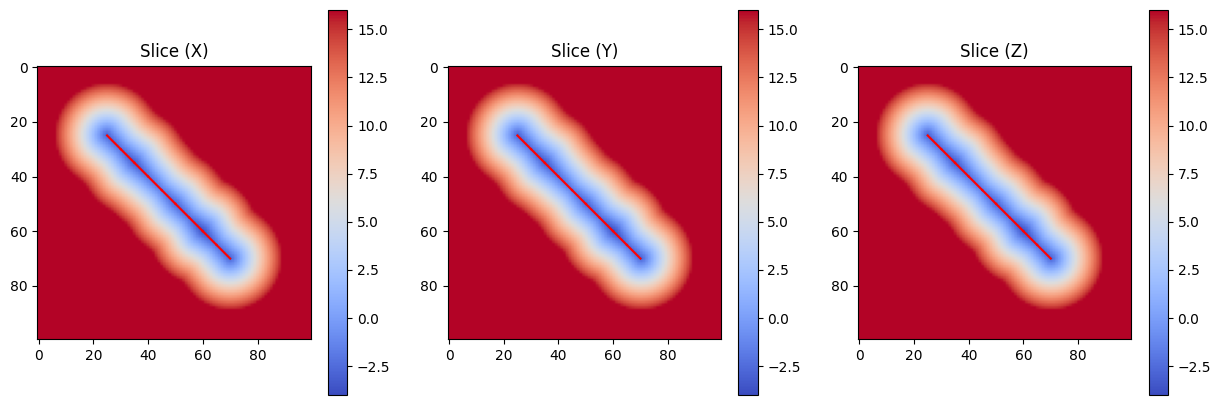

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/2539614602.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect.abs()), g)


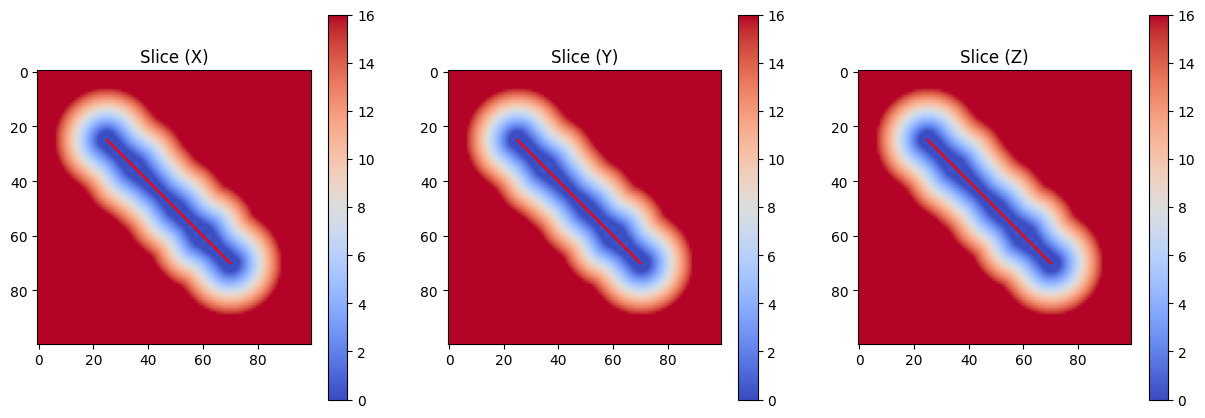

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/2539614602.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


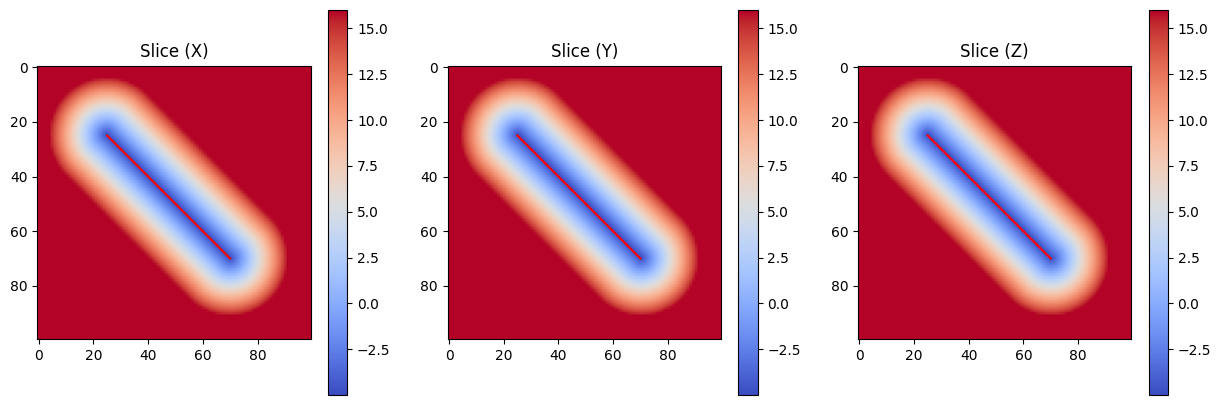

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/2539614602.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect.abs()), g)


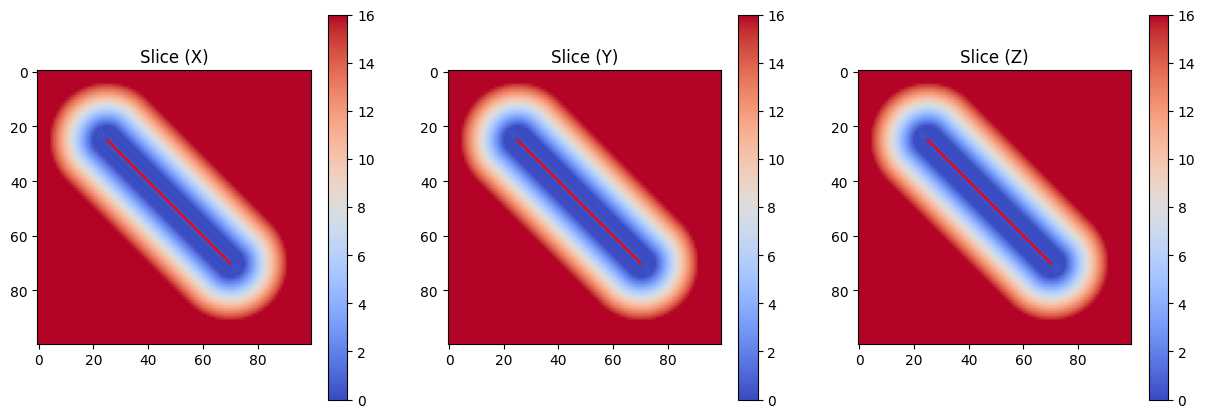

In [106]:
g = nx.Graph()
widths = th.tensor([10.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop,stepsz, alpha, beta, dim=ndims)
pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect), g)
show_slices(np.array(pred_perfect.abs()), g)

s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect), g)
show_slices(np.array(pred_perfect.abs()), g)

pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/4132240163.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(pred_perfect)


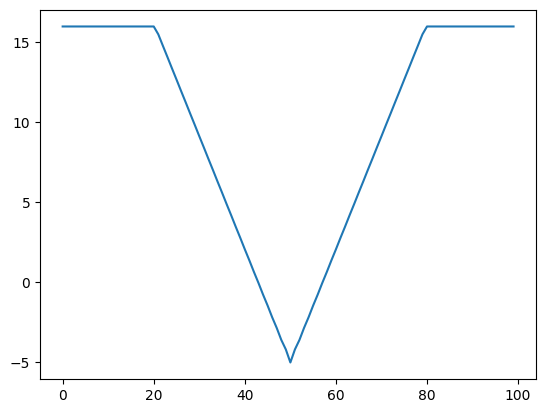

In [107]:
d = np.array(pred_perfect)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [99]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = pred_perfect.clone()[None,None]
predw = th.abs(pred_perfect).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

In [ ]:
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10,0]) 

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/777338654.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


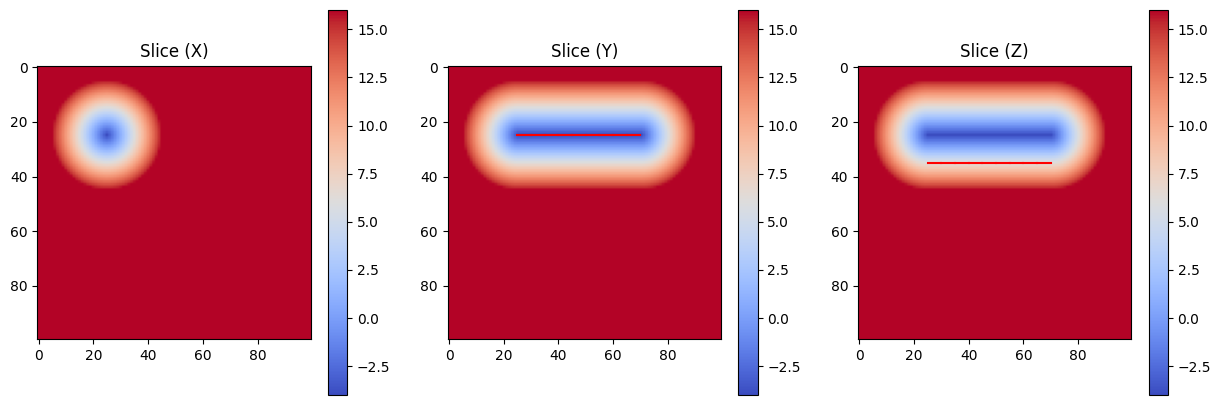

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/777338654.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


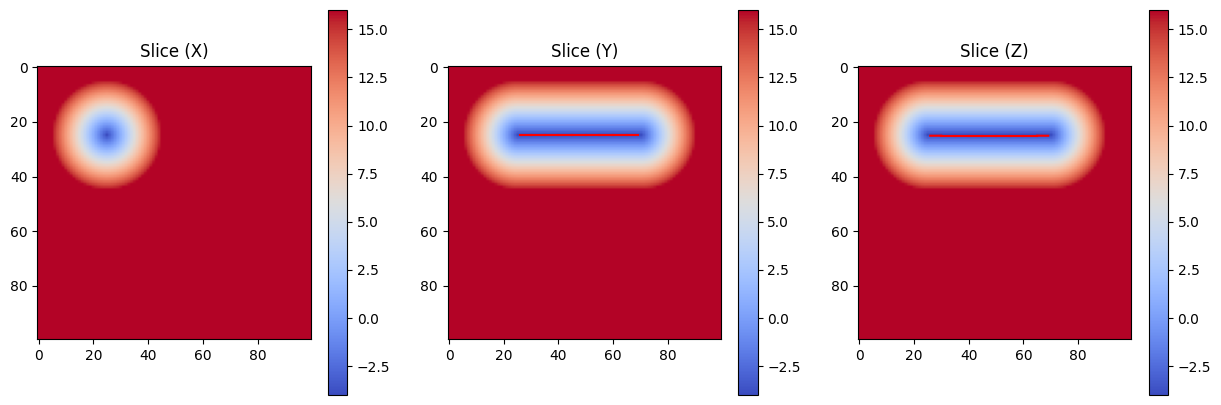

In [102]:
dim=3
sa = GradImRib(g,crop,stepsz,alpha,beta,dim,gimgv,gimgw)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
show_slices(np.array(predv[0][0]), g)

last = sa.optim(30,20)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [103]:
sa.get_w()

tensor([7.6817, 7.6936, 7.7007, 7.7032, 7.7048, 7.7048, 7.7032, 7.7009, 7.6972,
        7.6817])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/3650761698.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect.detach()), g)


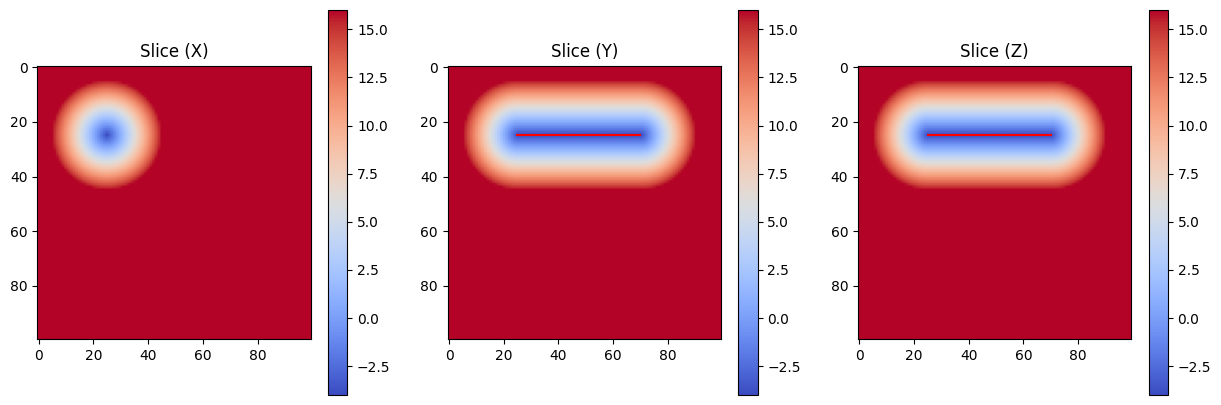

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/3650761698.py:43: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_initial2[0][0].detach()), g)


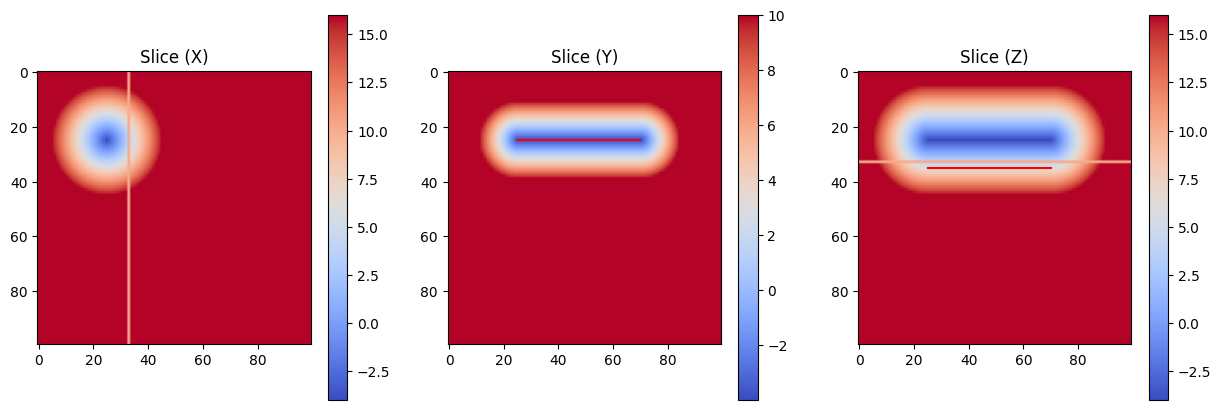

Iteration 0, Loss: 3.0803871154785156


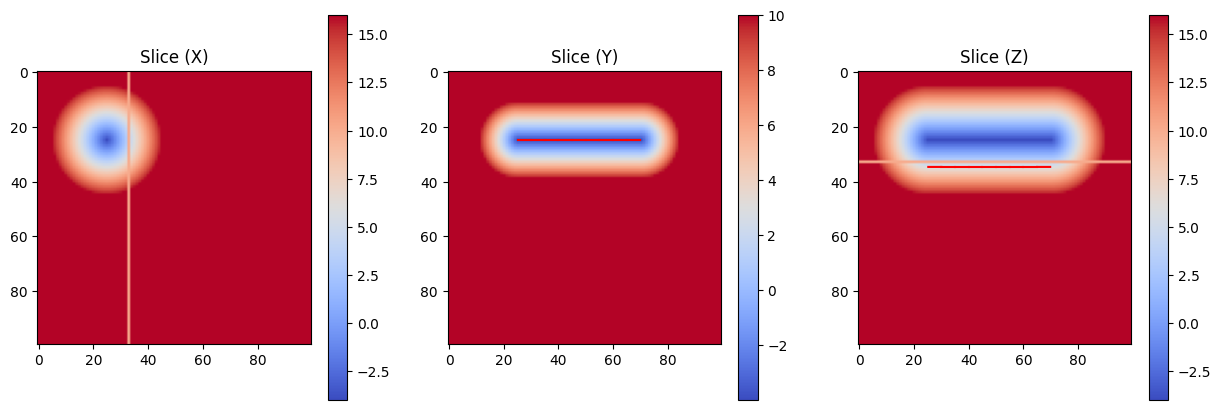

Iteration 10, Loss: 3.1030468940734863


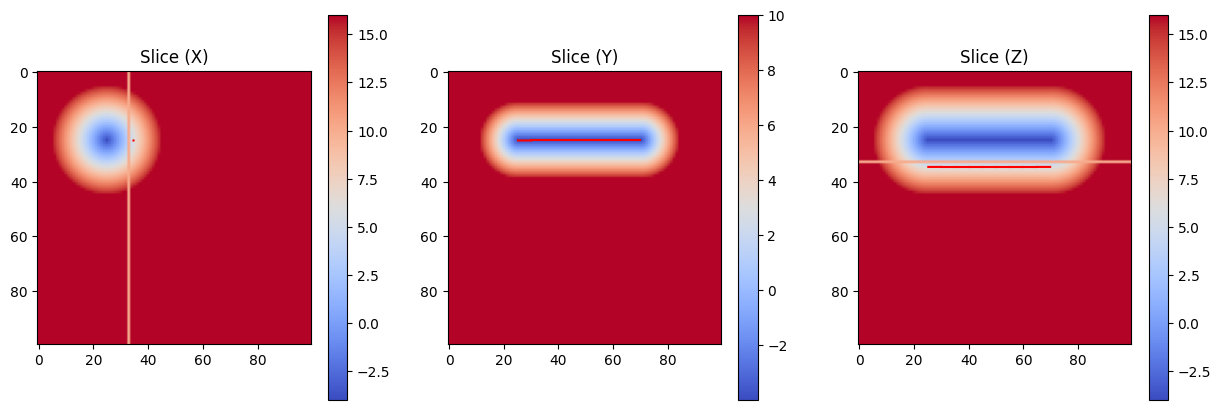

Iteration 20, Loss: 3.120382070541382


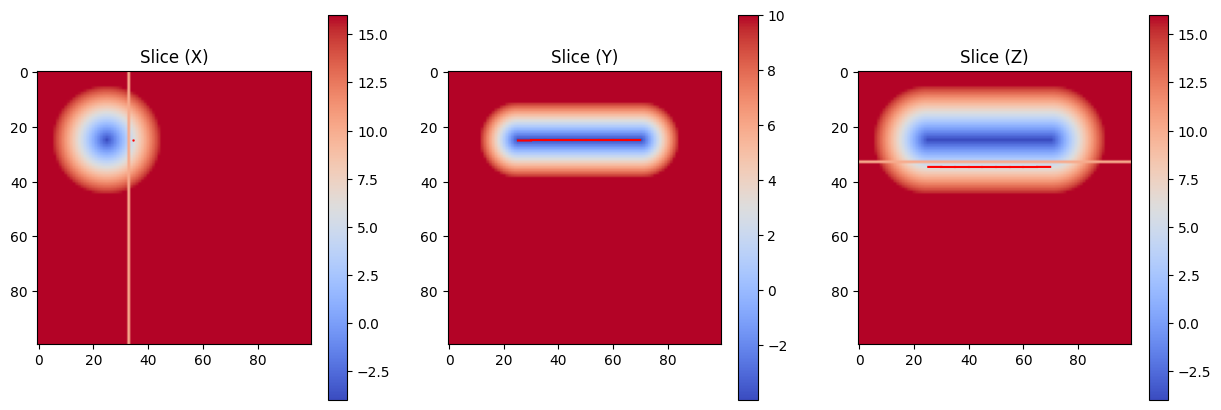

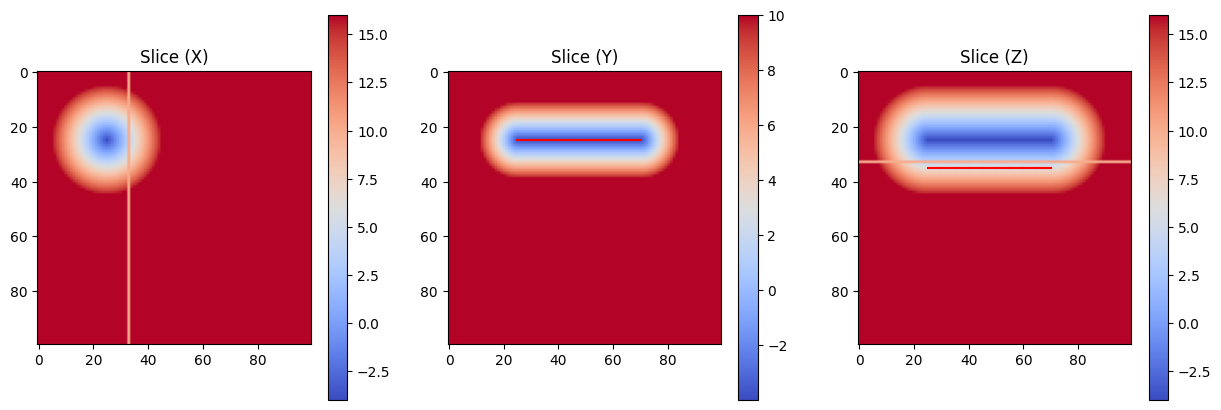

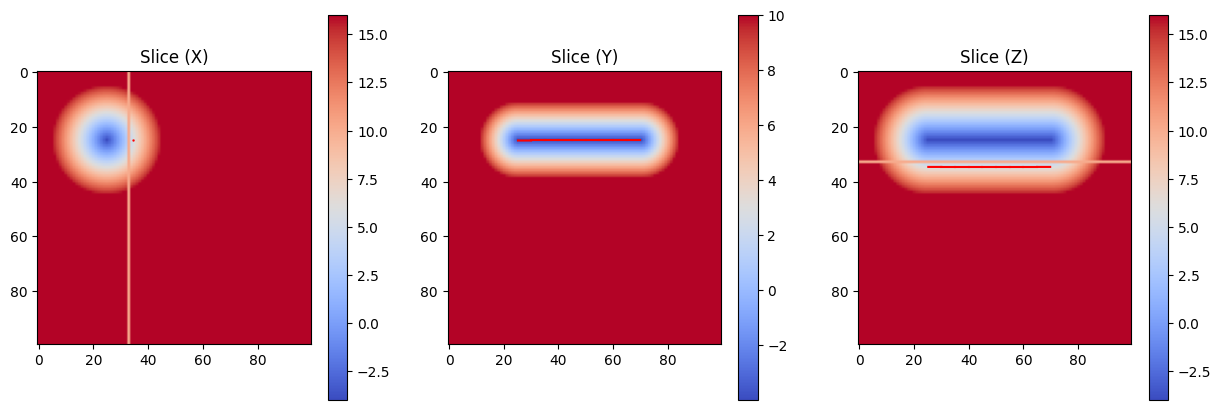

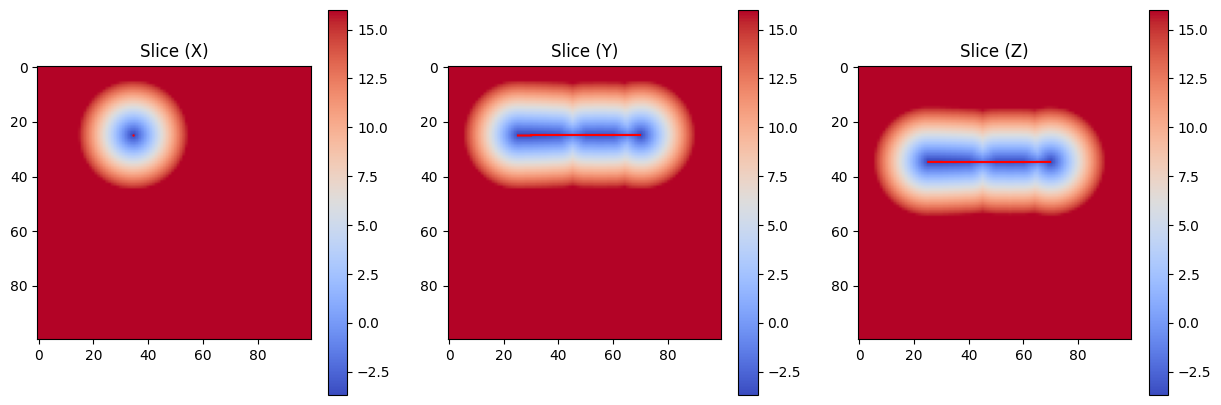

In [108]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)

""" g.add_node(16, pos=np.array([25,40,40]))
g.add_edge(16,5)
g.add_node(17, pos=np.array([50,40,30]))
g.add_edge(17,10) """
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0001
beta = 0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop,stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

# unet output
pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect.detach()), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial2[:,:,:,33:34,:] = 10.0

""" pred=pred_initial.clone()
pred.requires_grad_(True) """
pred2=pred_initial2.clone().detach()
pred2.requires_grad_(True)

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10,0]) 

show_slices(np.array(pred_initial2[0][0].detach()), g)

fltrstdev=0.5

opt = optim.SGD([pred2], lr=0.001, momentum=0.0)

extgradfac=1.0
nsteps=30
loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps
                        ,crop    ,16,4,extgradfac)

for i in range(30):
    opt.zero_grad()
    loss_val = loss.forward(pred2, [g])
    loss_val.backward()
    # optimization is done on pred2
    opt.step()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss_val.item()}")
    if i % 10 == 0:
        show_slices(pred2.clone().detach()[0][0].numpy(), loss.snake.getGraph())

show_slices(pred2.detach().cpu().numpy()[0, 0], g)

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show_slices(final_pred[0][0].numpy(), loss.snake.getGraph())

dm = loss.snake.render_distance_map_with_widths((100,100,100))
show_slices(dm.detach().numpy(), loss.snake.getGraph())

In [36]:
loss.snake.get_w()

tensor([7.8563, 7.8643, 7.8529, 7.8487, 7.8214, 7.8379, 7.8186, 7.8371, 7.8176,
        7.8293])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_23451/1058957804.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(loss.snake.render_distance_map_with_widths((100,100,100)).detach()), loss.snake.getGraph())


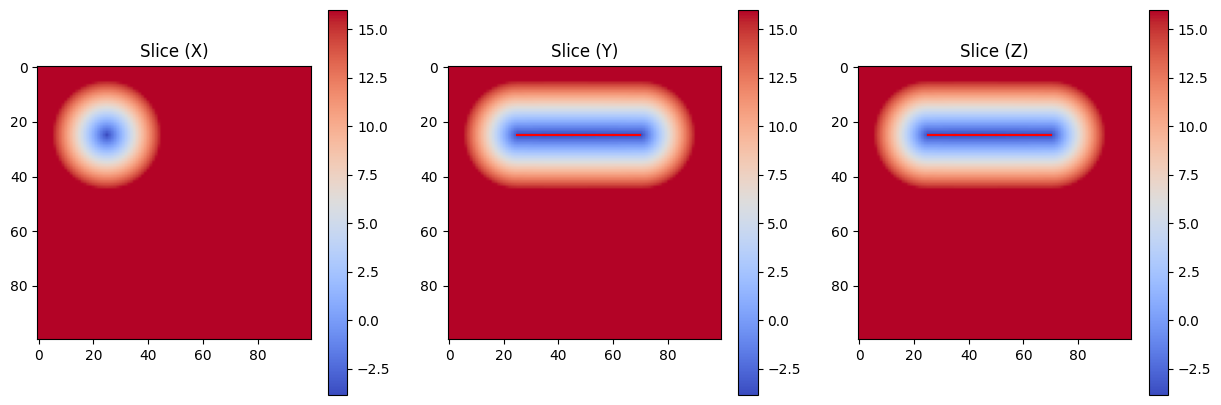

In [62]:
show_slices(np.array(loss.snake.render_distance_map_with_widths((100,100,100)).detach()), loss.snake.getGraph())

# 2d

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/3267368788.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_perfect), "2D", g)


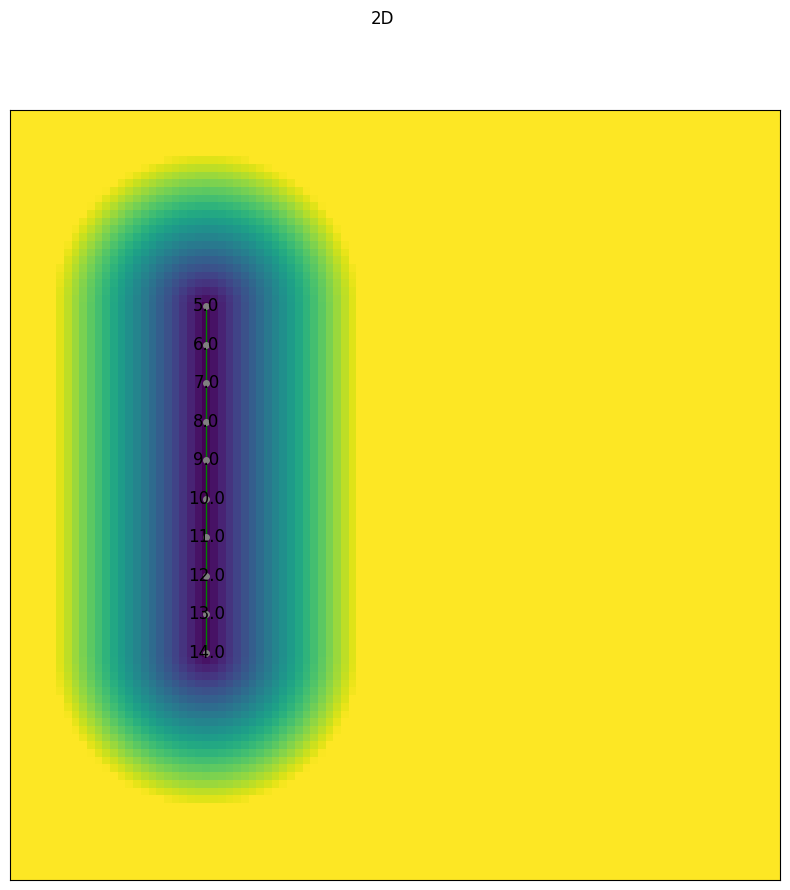

In [109]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0001
beta = 0.01
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100))
 
show(np.array(pred_perfect), "2D", g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [110]:
fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = pred_perfect.clone()[None,None]
predw = th.abs(pred_perfect).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

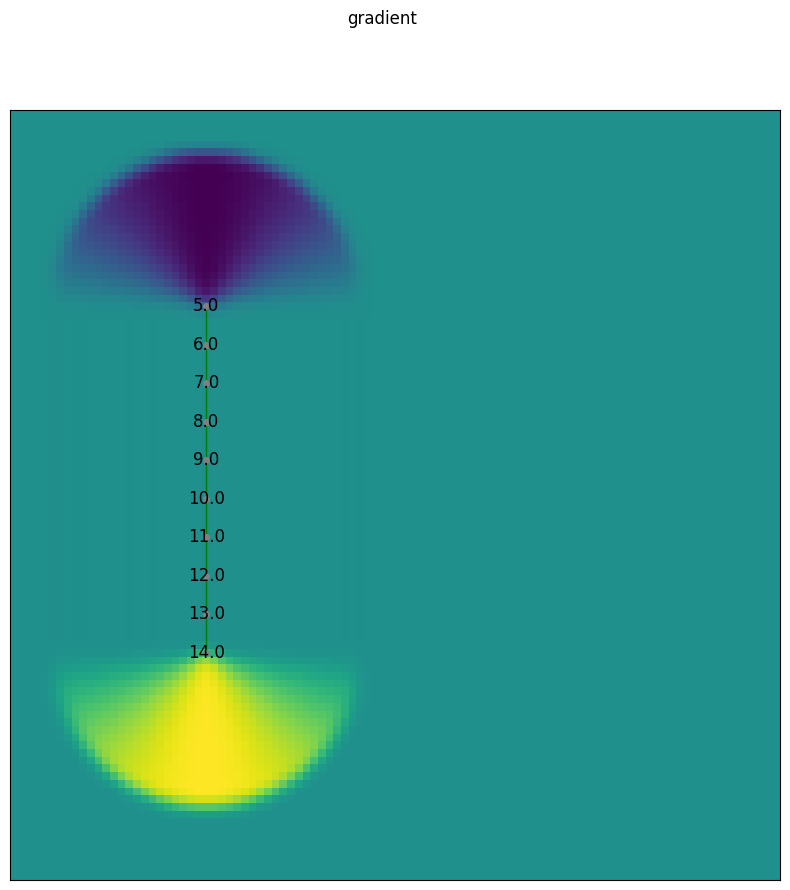

In [112]:
show(gimgv[0], "gradient", g)

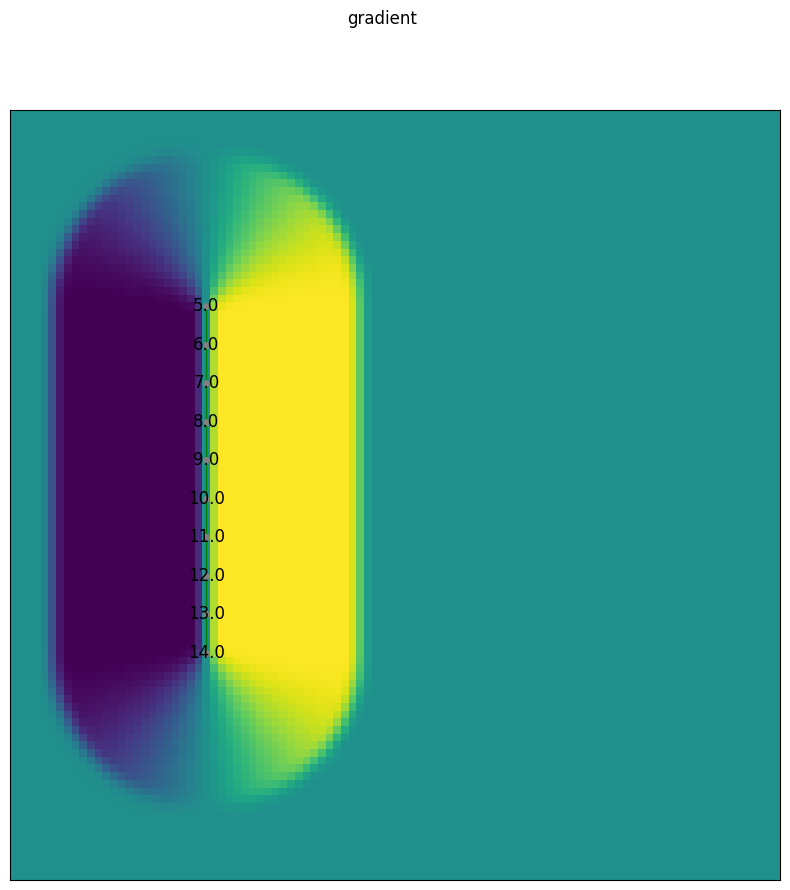

In [113]:
show(gimgv[1], "gradient", g)

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/777338654.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


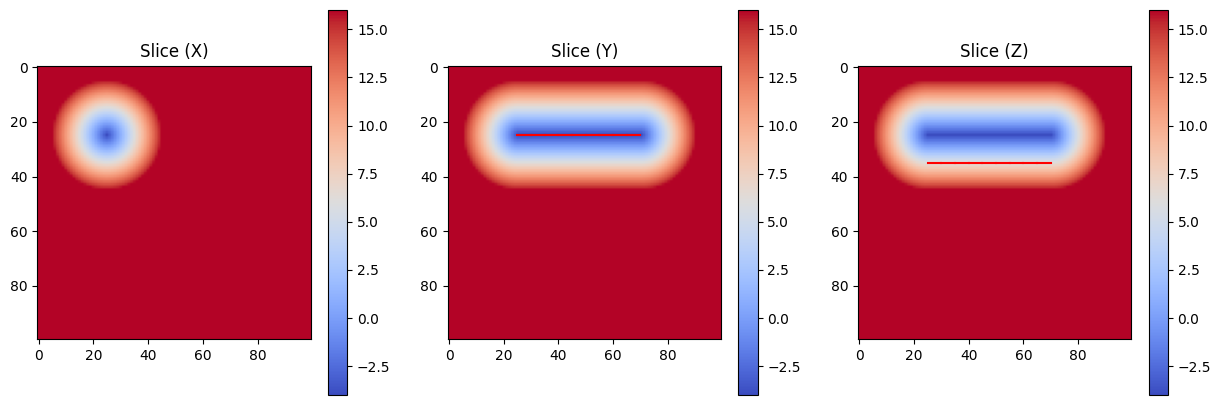

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_16202/777338654.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


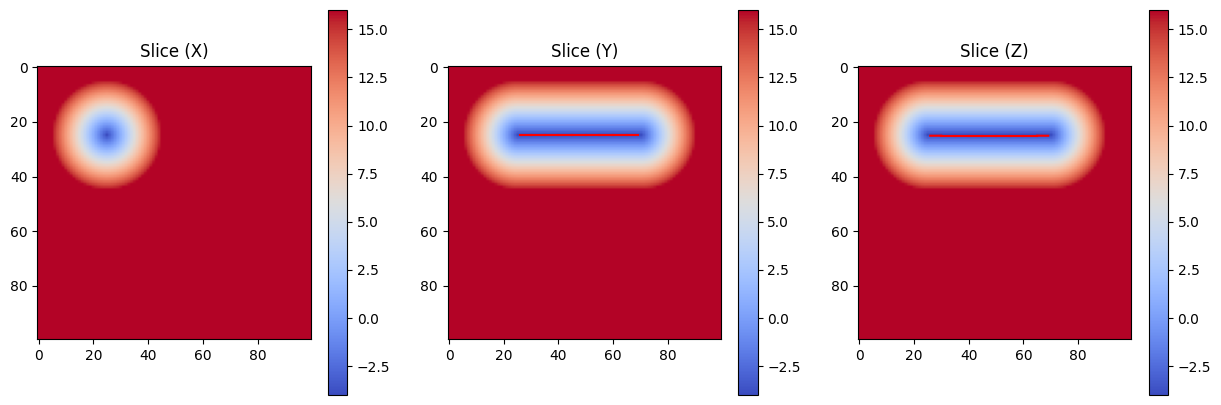

In [ ]:
dim=2
sa = GradImRib(g,crop,stepsz,alpha,beta,dim,gimgv,gimgw)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
show_slices(np.array(pred_perfect), g)

last = sa.optim(30,20)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(pred_perfect), sa.getGraph())

In [19]:
pred_initial2[:,:,:,33:34] = 6.0
pss = pred_initial2[0][0]

In [20]:
pss.shape

torch.Size([100, 100])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/1881745071.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pss), "", g)


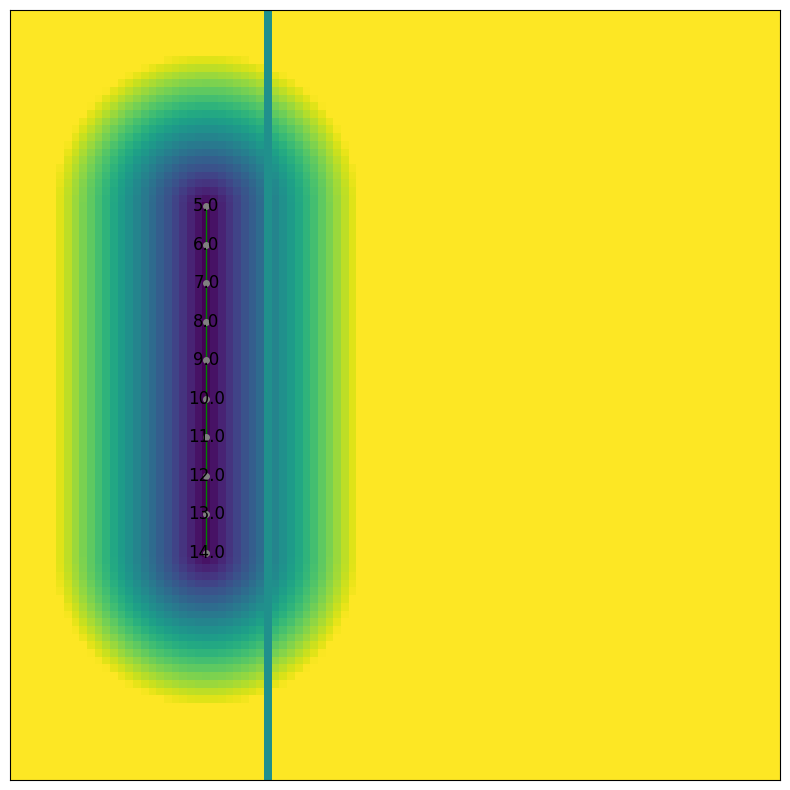

In [21]:
show(np.array(pss), "", g)

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_perfect.detach()), "",g)


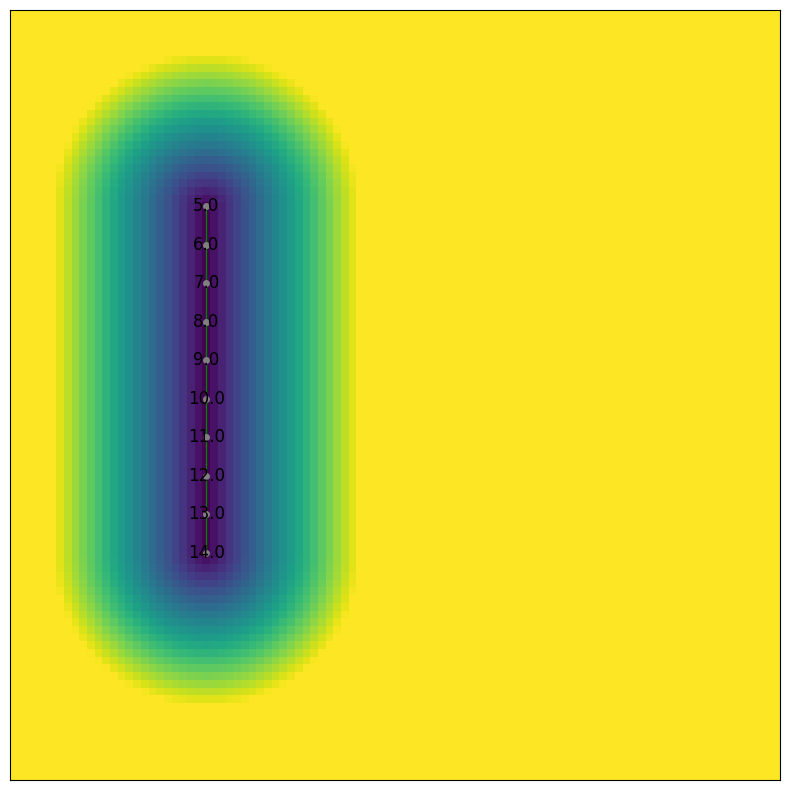

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_initial2[0][0].detach()), "", g)


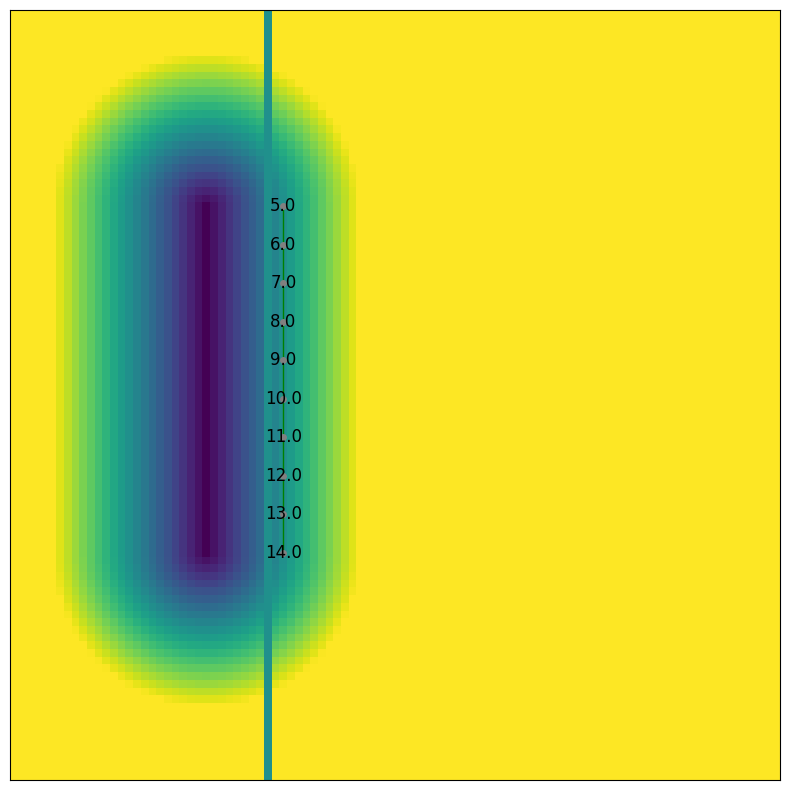

Iteration 0, Loss: 0.6621066927909851


/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred2.clone().detach()[0][0]), i, loss.snake.getGraph())


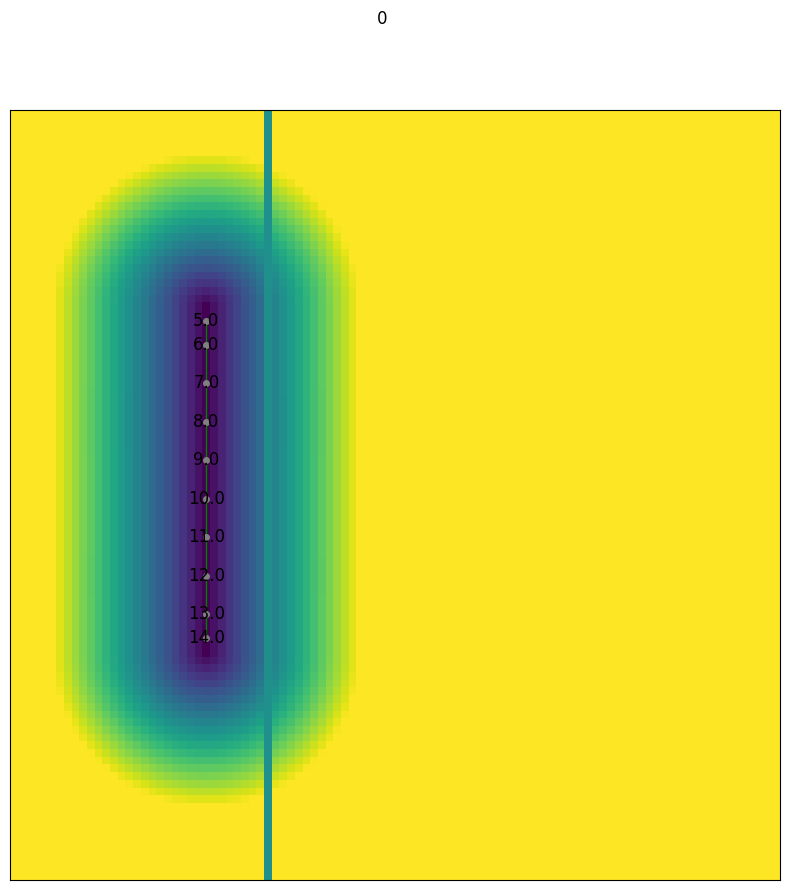

Iteration 10, Loss: 0.4901707172393799


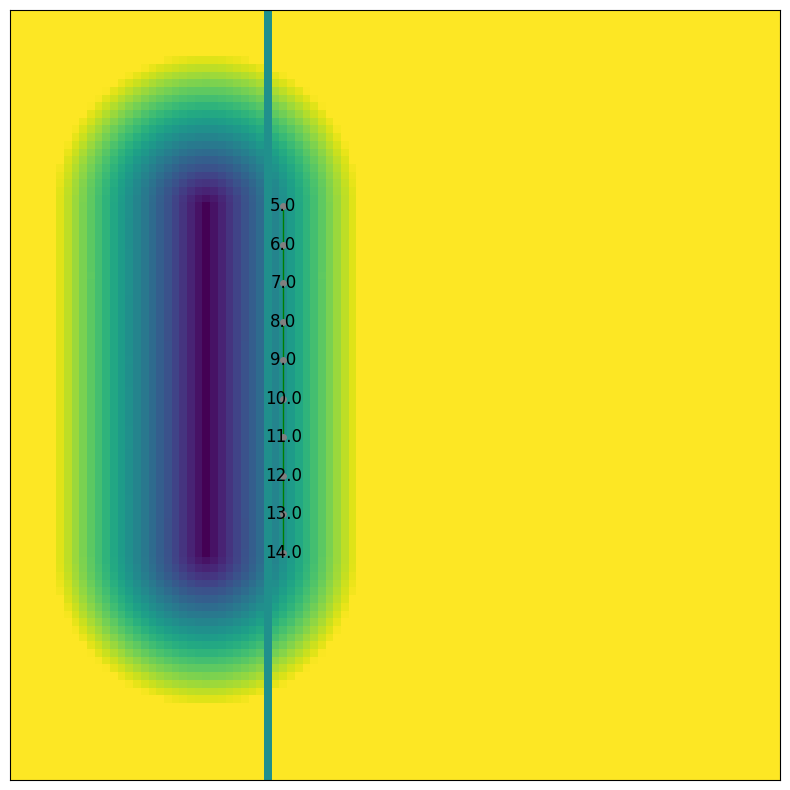

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:64: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(final_pred[0][0]), "",loss.snake.getGraph())


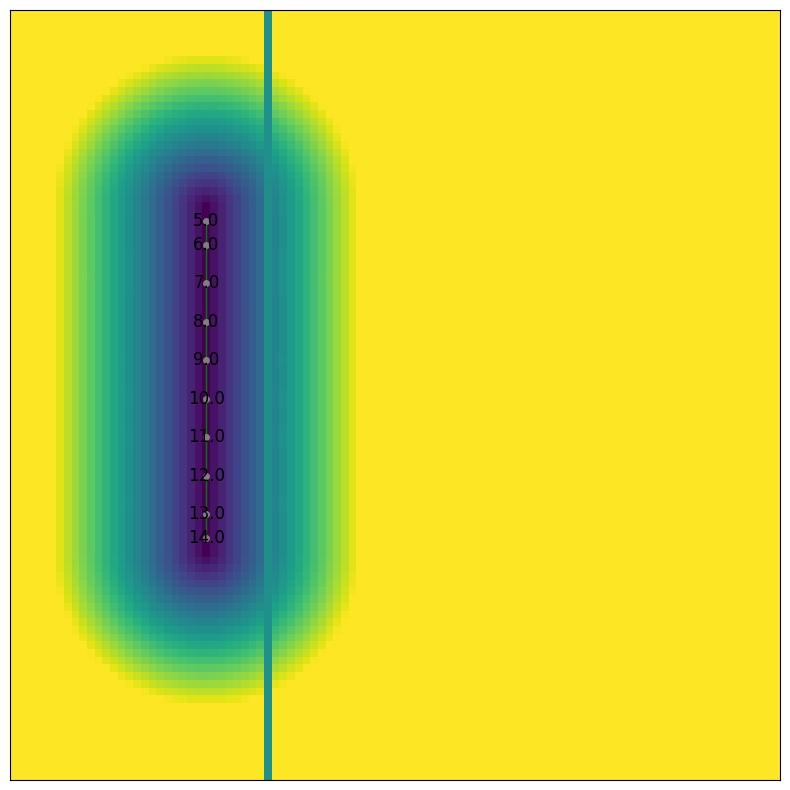

In [24]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 1
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims =2

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100))
 
show(np.array(pred_perfect.detach()), "",g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial2[:,:,:,33:34] = 6.0

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2 = pred_initial2.clone()
pred2.requires_grad_(True)

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10]) 

show(np.array(pred_initial2[0][0].detach()), "", g)

fltrstdev=1.0

opt = optim.SGD([pred2], lr=0.75, momentum=0.0)

extgradfac=1.0
nsteps=60
loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps, crop,
                                16,4,extgradfac)

for i in range(20):
    opt.zero_grad()
    loss_val = loss.forward(pred2, [g])
    loss_val.backward()
    # optimization is done on pred2
    opt.step()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss_val.item()}")
    if i % 50 == 0:
        show(np.array(pred2.clone().detach()[0][0]), i, loss.snake.getGraph())

show(pred2.detach().cpu().numpy()[0, 0], "",g)

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show(np.array(final_pred[0][0]), "",loss.snake.getGraph())

In [ ]:
loss.snake.get_w()

tensor([-0.1390, -0.1510, -0.0563,  0.0234,  0.0906,  0.1075,  0.0899,  0.0079,
        -0.0637, -0.0723])

------------------

C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3833761391.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tangents_tensor = torch.tensor(tangents, dtype=torch.float32, device=device)
C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3954249983.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(ddd), g)


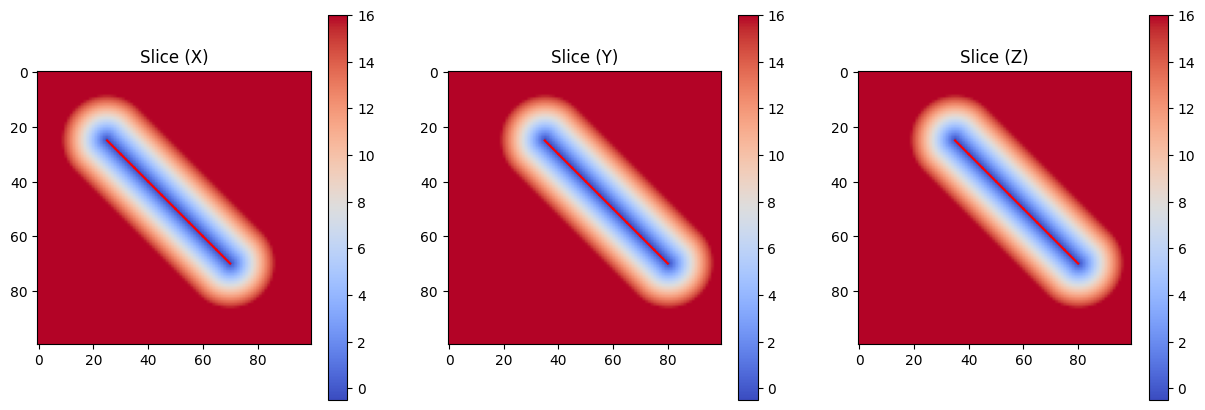

In [15]:
sa = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=3)
ddd = sa.render_distance_map((100,100,100))
show_slices(np.array(ddd), g)

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/1904502378.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


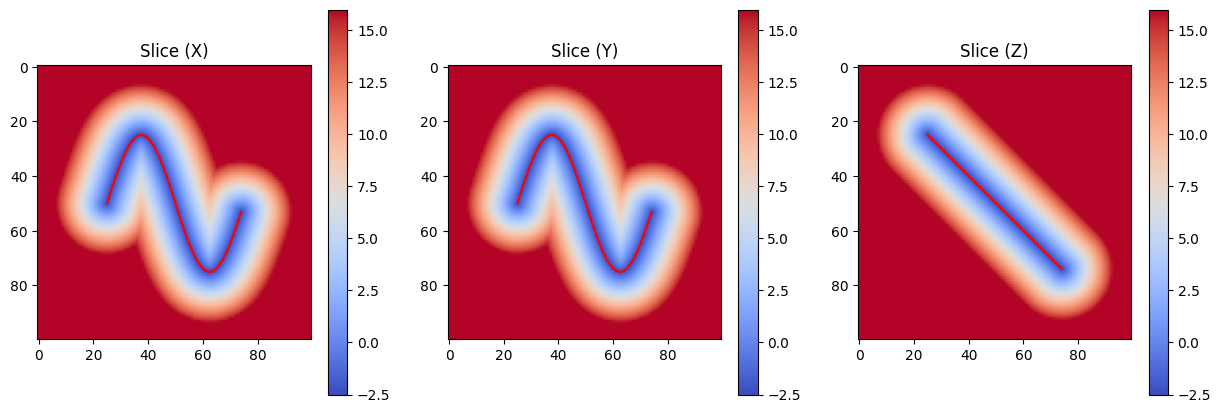

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/1904502378.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect.abs()), g)


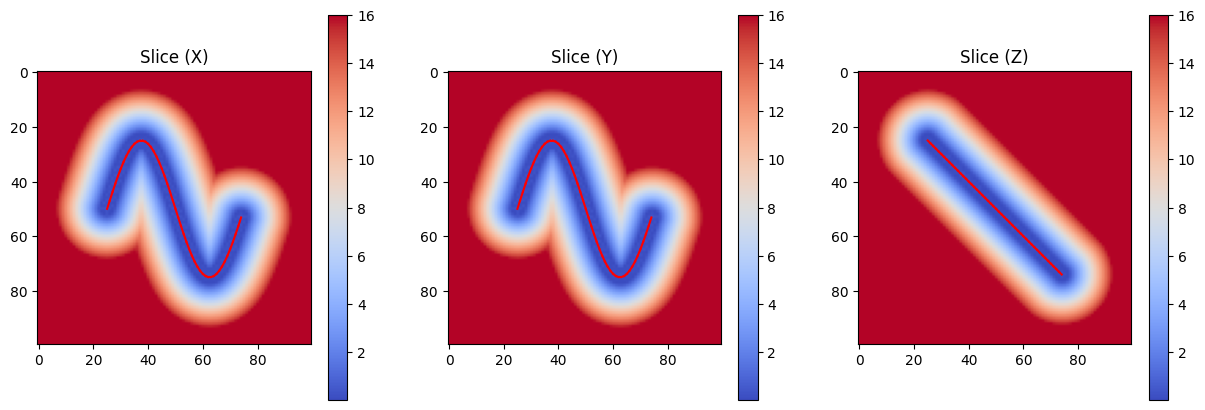

In [42]:
widths = th.tensor([5.0]*50,dtype=th.float32)
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop,stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect), g)
show_slices(np.array(pred_perfect.abs()), g)

pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [43]:
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,4,0])

In [44]:
pred_set = pred_perfect.clone()
pred_set[pred_set>0] = 16.0

In [58]:
pred_perfect[:,33:34,:] = 16.0

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/1069809056.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), None)


AttributeError: 'NoneType' object has no attribute 'edges'

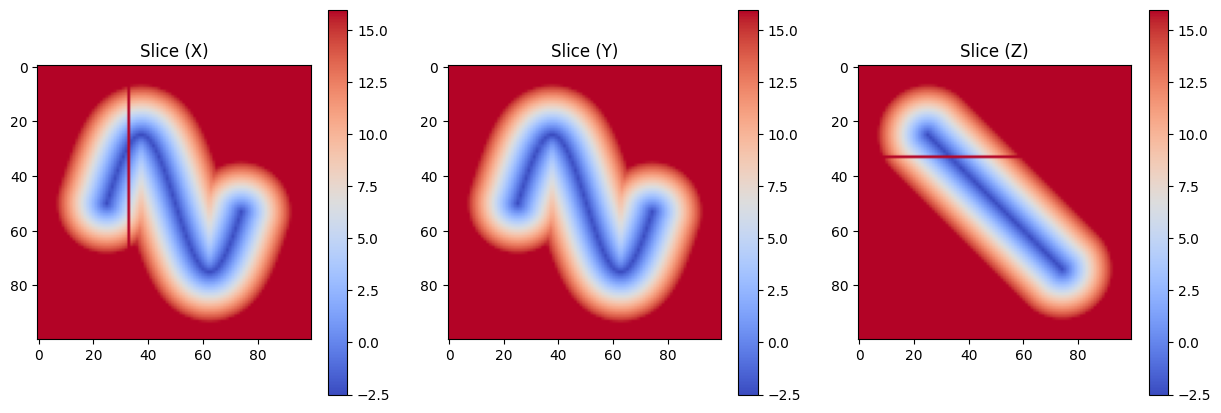

In [59]:
show_slices(np.array(pred_perfect), None)

In [ ]:
plt()

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/2760908099.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_set), g)


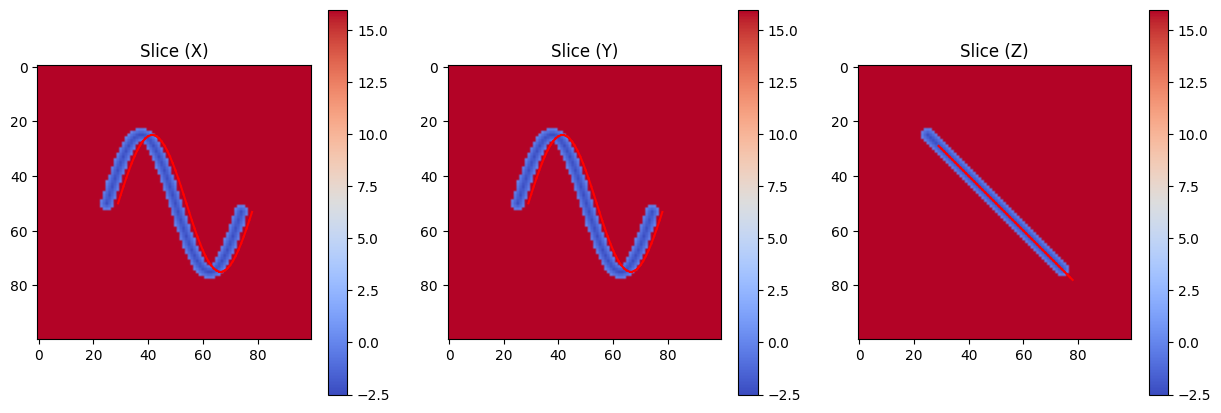

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/2760908099.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_set.abs()), g)


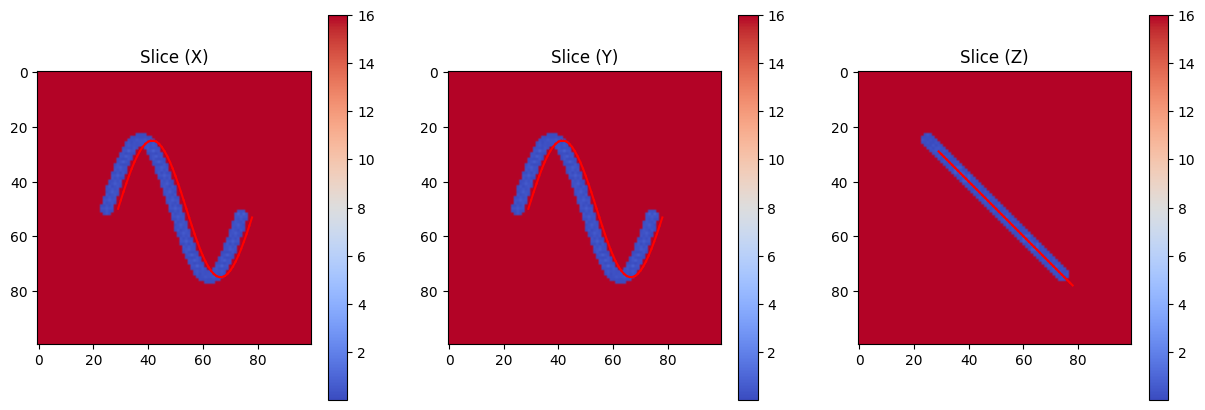

In [45]:
show_slices(np.array(pred_set), g)
show_slices(np.array(pred_set.abs()), g)

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/1828839496.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


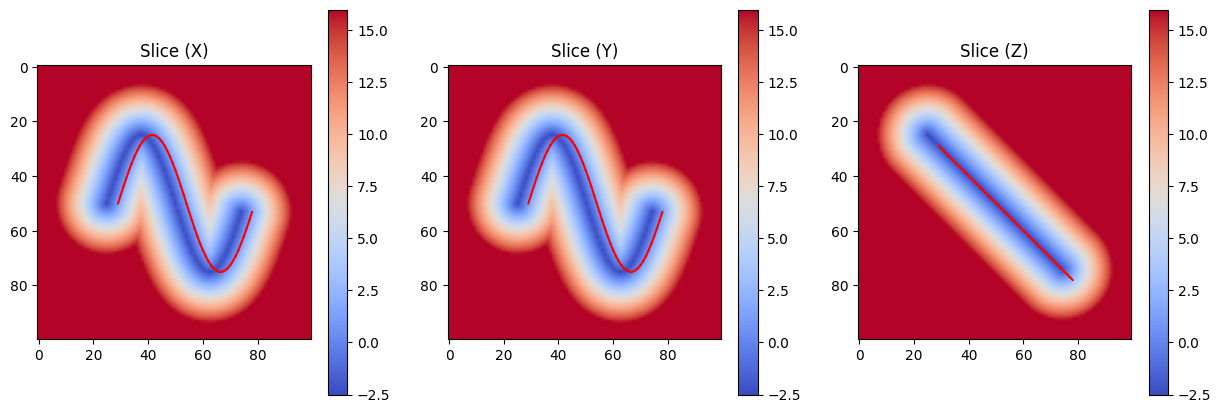

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/1828839496.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect.abs()), g)


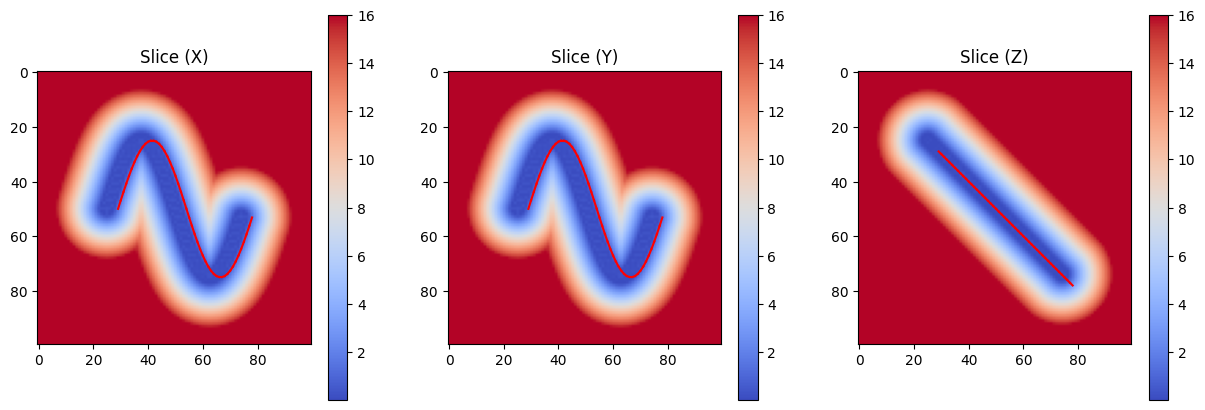

In [46]:
show_slices(np.array(pred_perfect), g)
show_slices(np.array(pred_perfect.abs()), g)

In [47]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = pred_perfect.clone()[None,None]
predw = th.abs(pred_perfect).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


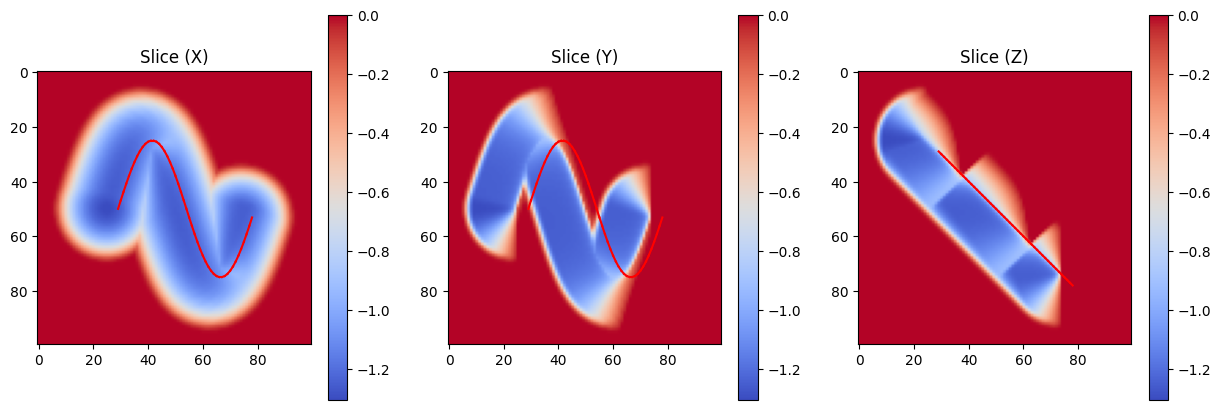

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


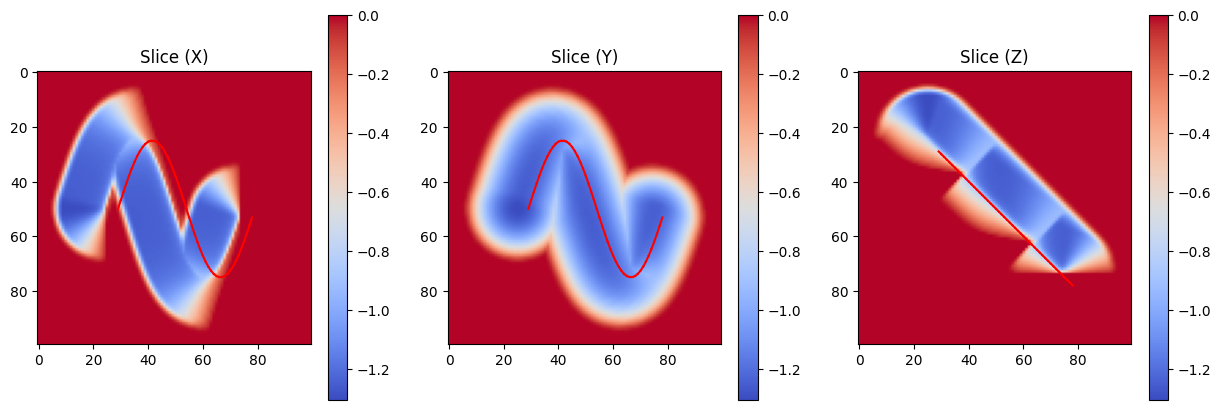

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


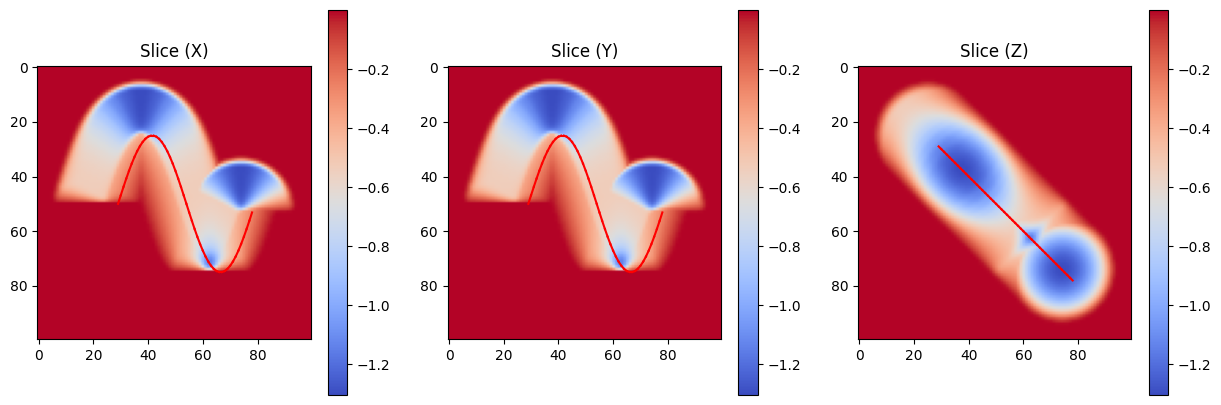

In [48]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [51]:
croprib=[slice(0,200), slice(0,200), slice(0,200)]

In [ ]:
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,4,0])

In [52]:
sa = GradImRib(g,croprib,stepsz,alpha,beta,3,gimgv,gimgw)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/3512332283.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


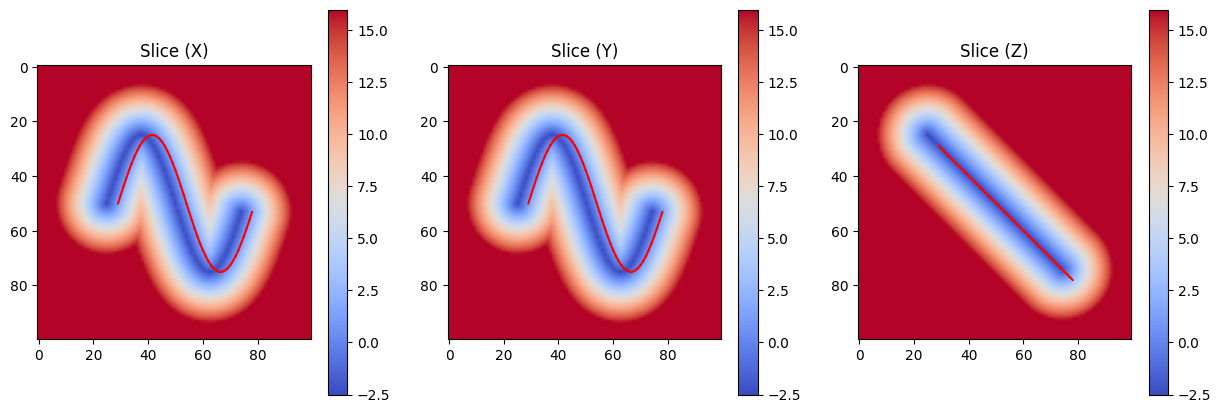

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_12438/3512332283.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


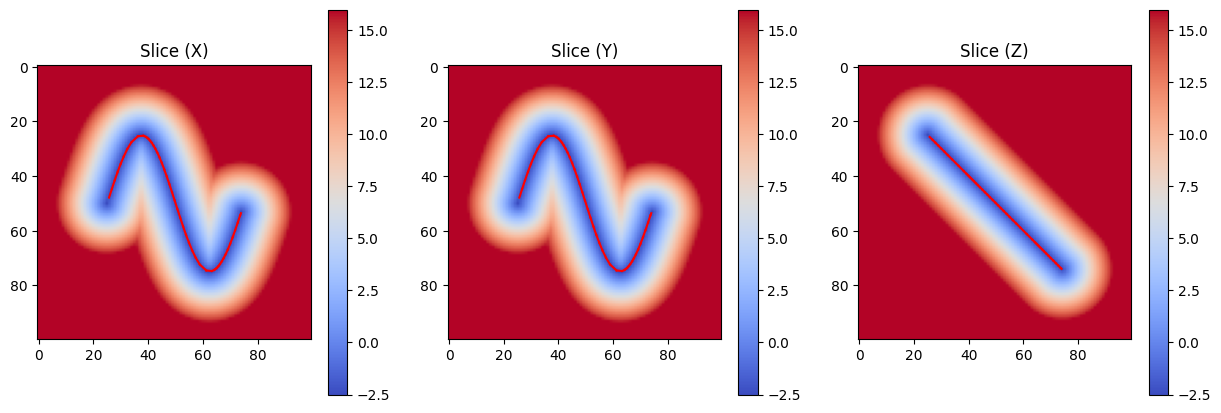

In [54]:

#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
print(sa.get_w())
show_slices(np.array(predv[0][0]), g)

sa.optim(10,0)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [78]:
sa.get_w()

tensor([[2.4538],
        [3.9162],
        [4.3532],
        [4.3865],
        [4.3939],
        [4.3887],
        [4.3812],
        [4.3842],
        [4.4035],
        [4.4176],
        [4.4085],
        [4.4055],
        [4.4006],
        [4.3875],
        [4.3813],
        [4.3806],
        [4.3751],
        [4.3625],
        [4.3816],
        [4.3968],
        [4.3925],
        [4.3805],
        [4.3759],
        [4.3742],
        [4.3743],
        [4.3731],
        [4.3730],
        [4.3767],
        [4.3846],
        [4.3891],
        [4.3887],
        [4.3812],
        [4.3842],
        [4.4035],
        [4.4176],
        [4.4085],
        [4.4055],
        [4.4006],
        [4.3875],
        [4.3813],
        [4.3806],
        [4.3751],
        [4.3625],
        [4.3816],
        [4.3968],
        [4.3945],
        [4.3805],
        [4.3521],
        [3.9377],
        [2.4836]], device='cuda:0')

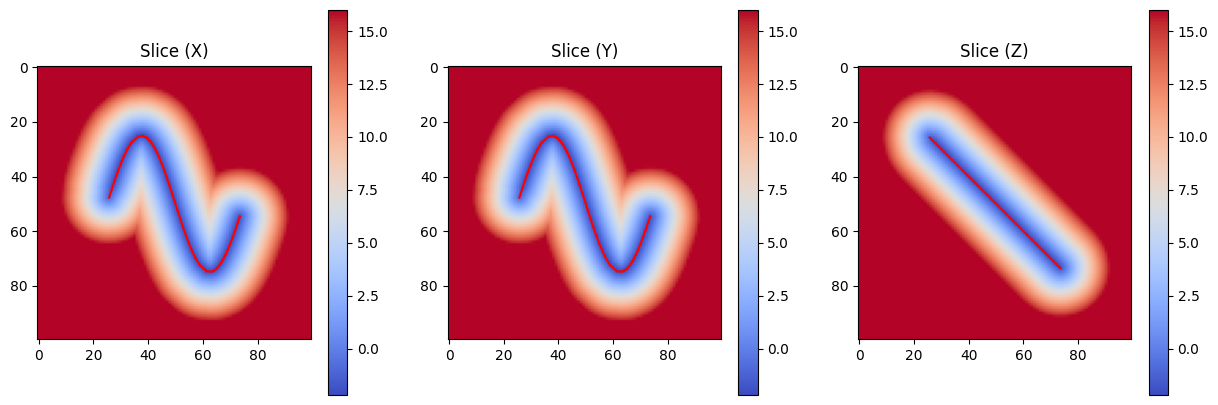

In [82]:
show_slices(sa.render_distance_map((100,100,100)).detach().cpu().numpy(), sa.getGraph()) 

In [87]:
newd = sa.render_distance_map((100,100,100)).detach().cpu().numpy()
diff = newd - predv.detach().cpu().numpy()[0][0]

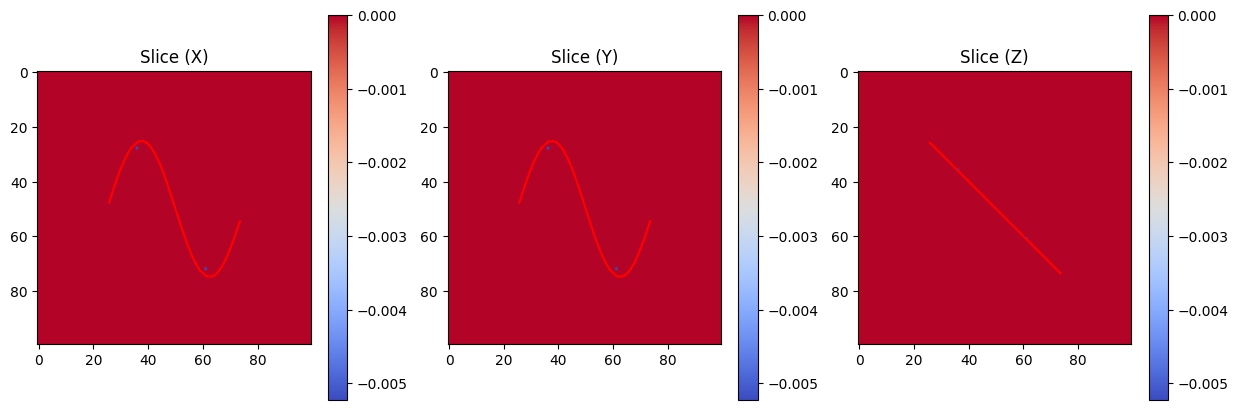

In [88]:
show_slices(diff, sa.getGraph())

In [55]:
from PIL import Image

# Load images in order
image1 = Image.open("noisy.png")
image2 = Image.open("optimized.png")

# Save as GIF
image1.save(
    "output.gif",
    save_all=True,
    append_images=[image2],
    duration=500,  # milliseconds between frames
    loop=0         # loop forever
)

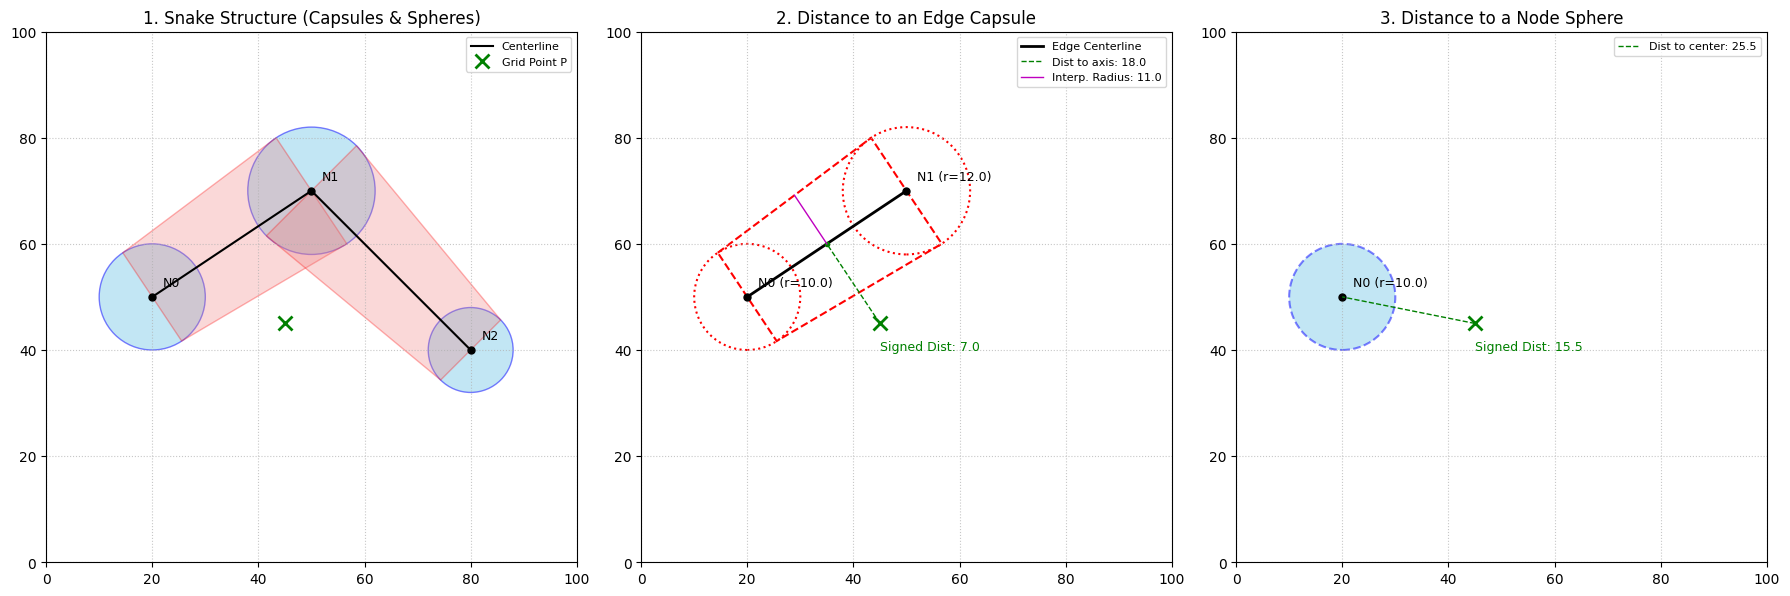

Visualization script finished.
Explanation:
Panel 1: Shows the overall snake structure. Blue circles are node 'spheres', red shaded areas are edge 'capsules'. The green 'x' is a sample grid point P.
Panel 2: Details the distance calculation from point P to the first edge capsule.
  - It shows the centerline of the edge, the capsule boundary (dashed red).
  - 'Dist to axis' is the shortest distance from P to the centerline segment.
  - 'Interp. Radius' is the radius of the capsule at that closest point on the axis.
  - 'Signed Dist' = (Dist to axis) - (Interp. Radius). This matches 'signed_dist_capsule' in your code.
Panel 3: Details the distance calculation from P to the first node's sphere.
  - 'Dist to center' is the distance from P to the node's center.
  - 'Signed Dist' = (Dist to center) - (Node Radius). This matches 'signed_dist_sphere' in your code.

The final distance map value for point P would be the MINIMUM of all such signed distances (to all capsules and all spheres).
A fu

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon
from matplotlib.collections import PatchCollection

def plot_snake_and_distance_concept(snake_nodes, snake_edges, radii, grid_point):
    """
    Generates a visualization for the distance map calculation concept.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Panel 1: Snake with capsules and spheres ---
    ax = axs[0]
    ax.set_title("1. Snake Structure (Capsules & Spheres)")
    ax.set_aspect('equal')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Plot nodes as circles (spheres in 2D)
    for i, node_pos in enumerate(snake_nodes):
        ax.add_patch(Circle(node_pos, radii[i], color='skyblue', alpha=0.5, ec='blue'))
        ax.plot(node_pos[0], node_pos[1], 'ko', markersize=5)
        ax.text(node_pos[0] + 2, node_pos[1] + 2, f"N{i}", fontsize=9)

    # Plot edges and their capsules
    for edge_idx, edge in enumerate(snake_edges):
        p1_idx, p2_idx = edge
        p1 = snake_nodes[p1_idx]
        p2 = snake_nodes[p2_idx]
        r1 = radii[p1_idx]
        r2 = radii[p2_idx]

        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', lw=1.5, label="Centerline" if edge_idx == 0 else "")

        # Capsule visualization (simplified for 2D)
        # Vector along the edge
        vec = p2 - p1
        vec_len = np.linalg.norm(vec)
        if vec_len > 1e-6:
            unit_vec = vec / vec_len
            # Perpendicular vector
            perp_vec = np.array([-unit_vec[1], unit_vec[0]])

            # Points for the capsule polygon
            cap_pts = [
                p1 + perp_vec * r1,
                p2 + perp_vec * r2,
                p2 - perp_vec * r2,
                p1 - perp_vec * r1
            ]
            ax.add_patch(Polygon(cap_pts, closed=True, color='lightcoral', alpha=0.3, ec='red'))
    
    ax.plot(grid_point[0], grid_point[1], 'gx', markersize=10, mew=2, label="Grid Point P")
    ax.legend(fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.7)

    # --- Panel 2: Distance to a Capsule ---
    ax = axs[1]
    ax.set_title("2. Distance to an Edge Capsule")
    ax.set_aspect('equal')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Focus on the first edge
    p1_idx, p2_idx = snake_edges[0]
    p1 = snake_nodes[p1_idx]
    p2 = snake_nodes[p2_idx]
    r1 = radii[p1_idx]
    r2 = radii[p2_idx]

    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', lw=2, label="Edge Centerline")
    ax.plot(p1[0], p1[1], 'ko', markersize=5)
    ax.text(p1[0] + 2, p1[1] + 2, f"N{p1_idx} (r={r1:.1f})", fontsize=9)
    ax.plot(p2[0], p2[1], 'ko', markersize=5)
    ax.text(p2[0] + 2, p2[1] + 2, f"N{p2_idx} (r={r2:.1f})", fontsize=9)
    
    # Capsule boundary
    vec = p2 - p1
    vec_len = np.linalg.norm(vec)
    if vec_len > 1e-6:
        unit_vec = vec / vec_len
        perp_vec = np.array([-unit_vec[1], unit_vec[0]])
        cap_pts_outline = [
            p1 + perp_vec * r1,
            p2 + perp_vec * r2,
            p2 - perp_vec * r2,
            p1 - perp_vec * r1
        ]
        ax.add_patch(Polygon(cap_pts_outline, closed=True, fill=False, color='red', lw=1.5, linestyle='--'))
        ax.add_patch(Circle(p1, r1, fill=False, color='red', lw=1.5, linestyle=':'))
        ax.add_patch(Circle(p2, r2, fill=False, color='red', lw=1.5, linestyle=':'))


    # Distance calculation for grid_point to this capsule's axis
    # Project grid_point onto the line segment p1-p2
    ap = grid_point - p1
    ab = p2 - p1
    
    t = np.dot(ap, ab) / np.dot(ab, ab)
    t_clamped = np.clip(t, 0, 1)
    
    closest_on_axis = p1 + t_clamped * ab
    dist_to_axis = np.linalg.norm(grid_point - closest_on_axis)
    
    # Interpolated radius
    interp_radius = r1 * (1 - t_clamped) + r2 * t_clamped
    signed_dist_capsule = dist_to_axis - interp_radius

    ax.plot(grid_point[0], grid_point[1], 'gx', markersize=10, mew=2)
    ax.plot([grid_point[0], closest_on_axis[0]], [grid_point[1], closest_on_axis[1]], 'g--', lw=1, label=f"Dist to axis: {dist_to_axis:.1f}")
    ax.plot(closest_on_axis[0], closest_on_axis[1], 'go', markersize=3)
    
    # Show interpolated radius at closest_on_axis
    ax.plot([closest_on_axis[0], closest_on_axis[0] + perp_vec[0]*interp_radius], 
            [closest_on_axis[1], closest_on_axis[1] + perp_vec[1]*interp_radius], 'm-', lw=1, label=f"Interp. Radius: {interp_radius:.1f}")

    ax.text(grid_point[0], grid_point[1] - 5, f"Signed Dist: {signed_dist_capsule:.1f}", color='green', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.7)

    # --- Panel 3: Distance to a Node Sphere ---
    ax = axs[2]
    ax.set_title("3. Distance to a Node Sphere")
    ax.set_aspect('equal')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Focus on the first node
    node_focus_idx = 0
    node_pos = snake_nodes[node_focus_idx]
    r_node = radii[node_focus_idx]

    ax.add_patch(Circle(node_pos, r_node, color='skyblue', alpha=0.5, ec='blue', lw=1.5, linestyle='--'))
    ax.plot(node_pos[0], node_pos[1], 'ko', markersize=5)
    ax.text(node_pos[0] + 2, node_pos[1] + 2, f"N{node_focus_idx} (r={r_node:.1f})", fontsize=9)

    dist_to_center = np.linalg.norm(grid_point - node_pos)
    signed_dist_sphere = dist_to_center - r_node

    ax.plot(grid_point[0], grid_point[1], 'gx', markersize=10, mew=2)
    ax.plot([grid_point[0], node_pos[0]], [grid_point[1], node_pos[1]], 'g--', lw=1, label=f"Dist to center: {dist_to_center:.1f}")
    ax.text(grid_point[0], grid_point[1] - 5, f"Signed Dist: {signed_dist_sphere:.1f}", color='green', fontsize=9)
    
    ax.legend(fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Define a simple 2D snake
    # Node positions (centers from self.s)
    snake_nodes_np = np.array([
        [20, 50],  # Node 0
        [50, 70],  # Node 1
        [80, 40]   # Node 2
    ])
    
    # Edges (from self.h.edges, using indices of snake_nodes_np)
    snake_edges_np = [
        (0, 1),
        (1, 2)
    ]
    
    # Radii for each node (from self.w / 2.0)
    radii_np = np.array([10.0, 12.0, 8.0]) 

    # A sample grid point for illustration
    sample_grid_point = np.array([45, 45])

    plot_snake_and_distance_concept(snake_nodes_np, snake_edges_np, radii_np, sample_grid_point)

    print("Visualization script finished.")
    print("Explanation:")
    print("Panel 1: Shows the overall snake structure. Blue circles are node 'spheres', red shaded areas are edge 'capsules'. The green 'x' is a sample grid point P.")
    print("Panel 2: Details the distance calculation from point P to the first edge capsule.")
    print("  - It shows the centerline of the edge, the capsule boundary (dashed red).")
    print("  - 'Dist to axis' is the shortest distance from P to the centerline segment.")
    print("  - 'Interp. Radius' is the radius of the capsule at that closest point on the axis.")
    print("  - 'Signed Dist' = (Dist to axis) - (Interp. Radius). This matches 'signed_dist_capsule' in your code.")
    print("Panel 3: Details the distance calculation from P to the first node's sphere.")
    print("  - 'Dist to center' is the distance from P to the node's center.")
    print("  - 'Signed Dist' = (Dist to center) - (Node Radius). This matches 'signed_dist_sphere' in your code.")
    print("\nThe final distance map value for point P would be the MINIMUM of all such signed distances (to all capsules and all spheres).")
    print("A full distance map would compute this for all points in a grid, then typically be visualized with a colormap (e.g., coolwarm).")
